# Piso Firme and its hidden impact

## _Step 0:_ Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shap
from statsmodels.stats import diagnostic
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
import random
import lime 
import lime.lime_tabular as lime_tabular
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## _Step 1:_ Loading and preprocessing the data

In [2]:
DATA_FOLDER = 'DATA/'
HOUSEHOLD_DATASET = DATA_FOLDER + 'PisoFirme_AEJPol-20070024_household.dta'
INDIVIDUAL_DATASET = DATA_FOLDER + 'PisoFirme_AEJPol-20070024_individual.dta'

# Setting our colors (equal to the ones on the website)
COLOR_BLUE = '#0563bb'
COLOR_RED = '#B33951'

COLOR_BLUE_RGB = (5,99,187)
COLOR_RED_RGB = (179,57,81)

# Reading the data
individual = pd.read_stata(INDIVIDUAL_DATASET)
households = pd.read_stata(HOUSEHOLD_DATASET)

We need to preprocess the two datasets as the authors did in their paper. We have already explained how the preprocessing is made for the household dataset in our respective extensions.

In [3]:
# Taking the rows for which idcluster is not NaN
households = households[households.idcluster.notna()]
individual = individual[individual['idcluster'].notna()]

# Taking the names of the columns with at least one NaN value to create the respective dummy variables
nan_cols = households.columns[households.isna().any()].tolist()

# Creating the control features / dummy variables
null_df = households[nan_cols].isnull().astype(int).add_suffix('_missing')

# Adding the dummy variables to the original dataframe and replacing null values with 0
households = households.merge(null_df, left_index = True, right_index = True).fillna(0)

## _Step 2:_ Effect of Piso Firme on the average household's income growth between 2000 and 2005 and the natality rate in the same period

In this first task, we want to assess the effect of Piso Firme program on four variables: 
- `S_dem1`: proportion of Males 0-5yrs in household in 2005
- `S_dem5`: proportion of Females 0-5yrs in household in 2005 
- `S_incomepc`: total household income per capita in 2005 
- `S_assetspc`: total value of household assets per capita in 2005

We want to see if the program had a statistically significant hidden effect on those indicators for two reasons:

- Natality rate: we think that life condition improvements as the ones brought by Piso Firme might have an impact on the will to have children (with a positive or negative correlation). We check the number of children born between 2000 and 2005, which is the period Piso Firme took place for the treated households.
- Average income per capita and assets per capita (household level): maybe the program helped the treated families to improve their economical condition.

First of all we create all the functions that will help us to build a table similar to the paper's ones, but with our values. The only difference is that we don't use the "\*" notation used in the paper, but we explicitely report the p-values of each outcome on another row. To summarize, for each outcome we have the following rows:
- The **coefficient** for _dpisofirme_
- The **clustered standard deviation** (in square brackets)
- The **p-value** of the coefficient (the probability that the coefficient is zero. In other words, the probability that there is no correlation - in parentheses).
- The **effect of Pico Firme** as a percentage of the average in the control group: $\frac{(100 \cdot coefficient)}{control\_group\_mean}$

In [4]:
# Treatment variable in the ols model
KEY_PISO_FIRME = 'C(dpisofirme)[T.1.0]'

def fit_models(model1, model2, model3, outcome_vars, df):
    """
    Fit the three models
    
    :param model1: specify the control variables for the model 1
    :type model1: list
    :param model2: specify the control variables for the model 2
    :type model2: list
    :param model3: specify the control variables for the model 3
    :type model3: list
    :param outcome_vars: specify the outcome variables
    :type outcome_vars: dict
    
    :return: A dictonary where for each outcome variable, are placed the three models fitted
    :rtype: dict
    """
    model_results = {}
    
    for dv in outcome_vars:
        model_results[dv] = []
        model_results[dv].append(smf.ols(formula=dv + ' ~ ' + '+'.join(model1), data=df).fit(cov_type='cluster', cov_kwds = {'groups': df['idcluster']}))
        model_results[dv].append(smf.ols(formula=dv + ' ~ ' + '+'.join(model2), data=df).fit(cov_type='cluster', cov_kwds = {'groups': df['idcluster']}))
        model_results[dv].append(smf.ols(formula=dv + ' ~ ' + '+'.join(model3), data=df).fit(cov_type='cluster', cov_kwds = {'groups': df['idcluster']}))
    
    return model_results

def round_and_str(number):
    """
    Rounds a number to the first three decimal digits and return it as string.
    
    :param number: the number to which compute the operation
    :type number: float
    
    :return: The result as describe
    :rtype: str
    """
    
    return str(round(number, 3))

def show_table(control_means, control_stds, model_results, outcome_vars):
    """
    Fit the three models
    
    :param control_means: An array which specifies the mean for each outcome variable
    :type control_means: pandas.core.series.Series
    :param control_stds: An array which specifies the standard deviation for each outcome variable
    :type control_stds: pandas.core.series.Series
    :param model_results: A dictonary where are placed the three models fitted for each outocome variable
    :type model_results: dict
    :param outcome_vars: Specifies the outcome variables
    :type outcome_vars: dict
    
    :return: A DataFrame where are placed the coefficients, the clustered standard deviation and the the PicoFirm effect
    :rtype: pandas.core.frame.DataFrame
    """
    table_rows = []
    
    # For each outcome variable
    for key, value in dependent_variables.items():
        # Adding one row to show the dpisofirme coefficient for each model and the control group mean
        mean_std = round_and_str(control_means[key]) + " (" + round_and_str(control_stds[key]) + ")"
        coeff_model = [round_and_str(model_results[key][i].params[KEY_PISO_FIRME]) for i in range(len(model_results[key]))]
        table_rows.append([value, mean_std, coeff_model[0], coeff_model[1], coeff_model[2]])

        # Adding one row to show the clustered standard deviation for each model
        std_model = ["[" + round_and_str(model_results[key][i].bse[KEY_PISO_FIRME]) + "]" for i in range(len(model_results[key]))];
        table_rows.append([value, "",  std_model[0], std_model[1], std_model[2]])
        
        # Adding one row to show the p-value
        pvalue_model = ["(" + round_and_str(model_results[key][i].pvalues[KEY_PISO_FIRME]) + ")" for i in range(len(model_results[key]))];
        table_rows.append([value, "",  pvalue_model[0], pvalue_model[1], pvalue_model[2]])
        
        # Adding one row to relate the coefficient to the control mean in order to understand the effect of PisoFirme respect to control group
        effect_model = [round_and_str(100 * model_results[key][i].params[KEY_PISO_FIRME] / control_means[key]) for i in range(len(model_results[key]))]
        table_rows.append([value, "", effect_model[0], effect_model[1], effect_model[2]])

    # Creating the DataFrame
    return pd.DataFrame(np.array(table_rows), columns=['Dependent variable', 'Control group mean (std. dev.)', 'Model 1', 'Model 2', 'Model 3']).set_index(['Dependent variable', 'Control group mean (std. dev.)'])

In [5]:
# Independent regression variables list for the model 1
model_1_reg_variables = ['C(dpisofirme)']

# Independent regression variables list for the model 2
model_2_reg_variables = ['C(dpisofirme)', 'S_HHpeople', 'S_headage', 'S_spouseage', 'S_headeduc', 'C(S_headeduc_missing)', 'S_spouseeduc', ' C(S_spouseeduc_missing)', 
                         'S_dem2', 'S_dem3', 'S_dem4', 'S_dem6', 'S_dem7', 'S_dem8', 'C(S_hasanimals)', 'C(S_animalsinside)',
                                'C(S_waterland)', 'C(S_waterhouse)', 'C(S_electricity)', 'S_washhands', 'C(S_garbage)']

# Independent regression variables list for the model 3
model_3_reg_variables = model_2_reg_variables + ['S_cashtransfers', 'C(S_cashtransfers_missing)',
                                'C(S_milkprogram)', 'C(S_foodprogram)', 'C(S_seguropopular)']

# Keeping the relation between variable name and text label
dependent_variables = {'S_dem1':'Proportion of males 0-5yrs in household', 'S_dem5':'Proportion of females 0-5yrs in household', 'S_incomepc': 'Total household income per capita', 'S_assetspc': 'Total value of household assets per capita'}

model_results = fit_models(model_1_reg_variables, model_2_reg_variables, model_3_reg_variables, dependent_variables, households)

In [6]:
# Creating the control and the treatment group
control_group = households[households['dpisofirme'] == 0]
treatment_group = households[households['dpisofirme'] == 1]


# Mean and std deviation of each outcome variable for the control group
means = control_group[list(dependent_variables.keys())].mean()
stds = control_group[list(dependent_variables.keys())].std()

In [7]:
show_table(means, stds, model_results, dependent_variables)

Model 1  \
Dependent variable                         Control group mean (std. dev.)              
Proportion of males 0-5yrs in household    0.152 (0.146)                      -0.013   
                                                                             [0.005]   
                                                                             (0.006)   
                                                                              -8.773   
Proportion of females 0-5yrs in household  0.141 (0.137)                       0.001   
                                                                             [0.006]   
                                                                             (0.879)   
                                                                               0.624   
Total household income per capita          1050.166 (4248.046)               -26.216   
                                                                           [125.191]   
                                                                             (0.834)   
                                                                              -2.496   
Total value of household assets per capita 22032.338 (7318.447)              344.972   
                                                                           [400.662]   
                                                                             (0.389)   
                                                                               1.566   

                                                                             Model 2  \
Dependent variable                         Control group mean (std. dev.)              
Proportion of males 0-5yrs in household    0.152 (0.146)                      -0.007   
                                                                             [0.005]   
                                                                             (0.144)   
                                                                              -4.427   
Proportion of females 0-5yrs in household  0.141 (0.137)                       0.006   
                                                                             [0.005]   
                                                                             (0.233)   
                                                                               4.082   
Total household income per capita          1050.166 (4248.046)               -71.002   
                                                                           [130.744]   
                                                                             (0.587)   
                                                                              -6.761   
Total value of household assets per capita 22032.338 (7318.447)              112.913   
                                                                           [165.846]   
                                                                             (0.496)   
                                                                               0.512   

                                                                             Model 3  
Dependent variable                         Control group mean (std. dev.)             
Proportion of males 0-5yrs in household    0.152 (0.146)                      -0.008  
                                                                             [0.005]  
                                                                             (0.109)  
                                                                              -4.973  
Proportion of females 0-5yrs in household  0.141 (0.137)                       0.007  
                                                                             [0.005]  
                                                                             (0.167)  
                                                                               4.747  
Total household income per capita    

### _Substep 2.1:_ Interpreting the results

Our analysis shows that:
- For the natality rate, we can't say that the program had an effect on the outcome variables, namely the number of male and female children born between 2000 and 2005. Indeed, the p-value is lower than the common threshold (0.05) only in the first model, when we consider as outcome the proportion of males born between 2000 and 2005, and the program seems to have had a negative effect on this proportion. Anyway, considering that the other two models contradict this result, and considering that, when looking at the proportion of females born between 2000 and 2005 the p-values are all higher than the threshold, and the reported effect is insignificant, we definetly cannot state that Piso Firme had an effect on these variables. It would be certainly interesting to see the long-term effects of the program in this sense on the treated households, but unfortunately this kind of data is unavailable.

- Talking about the household income and assets per capita in 2005, first of all we notice that, for the control group, the standard deviation is huge. This suggests that these economical indicators have a huge variation across the families. Moreover, for the total household income per capita we notice an unexpected decrease for the treated group, but even in this case we can't state anything about Piso Firme effect, since the p-values are way higher than 0.05. With respect to the households assets, we notice, this time, an increase for the treated group, which is expected, since the value of a house increases whith the replacement of the floor's material. However, even in this case, we are not in the position to state anything, because of the p-values.

There's still a question that we want to answer about these results: why is the standard deviation for the last two outcome variables so high in the control group?

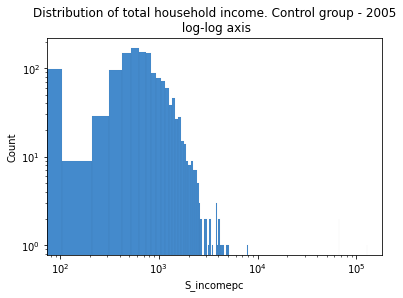

In [8]:
# First of all we try to plot the distribution of the income in a log-log fashion since it's heavy tailed
sns.histplot(data = control_group['S_incomepc'], color = COLOR_BLUE)
plt.yscale('log')
plt.xscale('log')
plt.title('Distribution of total household income. Control group - 2005\n log-log axis');
control_group['S_incomepc'].to_csv("./DATA/variance.csv")

The plot is still not interpretable: we notice that the x-axis is extended up to $10^5$. This suggests that there might be some really high values that skew the mean and the standard deviation.

In [9]:
# Top-10 household income
sorted_incomes = control_group.sort_values(by = 'S_incomepc', ascending = False)['S_incomepc']
sorted_incomes

1203    127266.664062
897      66447.226562
933      66408.335938
452       7990.000000
778       5066.666504
            ...      
958          0.000000
972          0.000000
973          0.000000
992          0.000000
696          0.000000
Name: S_incomepc, Length: 1393, dtype: float32

In [10]:
# Mean and std excluding the outliers
print(f'Mean and std of the variable S_incomepc excluding the outliers - Control group:\nMean: {sorted_incomes[4:].mean()}\nStd: {sorted_incomes[4:].std()}')

Mean and std of the variable S_incomepc excluding the outliers - Control group:
Mean: 860.1651611328125
Std: 625.1883544921875


Our intuition was correct: there are three households that earn way more than the others. The std is still high because the income difference is huge in the group, even without the outliers, but now it's more reasonable. The same analysis can be used to explain the huge std of the other variable, `S_assetspc`.

This brief analysis was just to satisfy our curiosity. Now back on track!

## _Step 3:_ Understanding SHAP values

Before starting to plot the SHAP values, we need to get a basic understanding of these values. We will walk you thorugh an example with a linear regression model on table 4 as, it is the simplest model to grasp. 
For linear regression, the shap values of a prediction are singular for each feature. Each SHAP value represents the contribution of the related feature to the difference between the expected value of the model and its prediction for that single datapoint, i.e: 

<center> $ f(x_{sample}) -  E[f(X)] = \sum_{features} SHAP_{feature} $ </center>

For this small walkthrough, we will consider as outcome the variable `S_shcementfloor` (Share of rooms with cement floors) and as independent variables, the ones considered by the third model in the 4th table of the paper, namely:

`dpisofirme`, `S_HHpeople`, `S_rooms`, `S_headage`, `S_spouseage`, `S_headeduc`, `S_spouseeduc`, `S_dem1`, `S_dem2`, `S_dem3`, `S_dem4`, `S_dem5`, `S_dem6`, `S_dem7`, `S_dem8`, `S_waterland`, `S_waterhouse`, `S_electricity`, `S_hasanimals`, `S_animalsinside`, `S_garbage`, `S_washhands`, `S_cashtransfers`, `S_milkprogram`,`S_foodprogram`, `S_seguropopular`.

**Note:** We are using the `S_rooms` variable because we refer to what was mentioned on the paper, not to the provided implementation (STATA code), in which it is missing.

Model coefficients:

dpisofirme = 0.2057
S_HHpeople = -0.016
S_rooms = 0.0526
S_headage = 0.0014
S_spouseage = 0.0013
S_headeduc = 0.0078
S_headeduc_missing = -0.0272
S_spouseeduc = 0.0044
S_spouseeduc_missing = 0.0241
S_dem1 = 0.0409
S_dem2 = 0.1781
S_dem3 = 0.0755
S_dem4 = -0.1038
S_dem5 = 0.057
S_dem6 = 0.1663
S_dem7 = 0.2131
S_dem8 = 0.1112
S_waterland = 0.0951
S_waterhouse = 0.0741
S_electricity = 0.0941
S_hasanimals = -0.0006
S_animalsinside = -0.0402
S_garbage = 0.0164
S_washhands = 0.0097
S_cashtransfers = -0.0002
S_cashtransfers_missing = 0.2712
S_milkprogram = 0.025
S_foodprogram = -0.0298
S_seguropopular = 0.0349


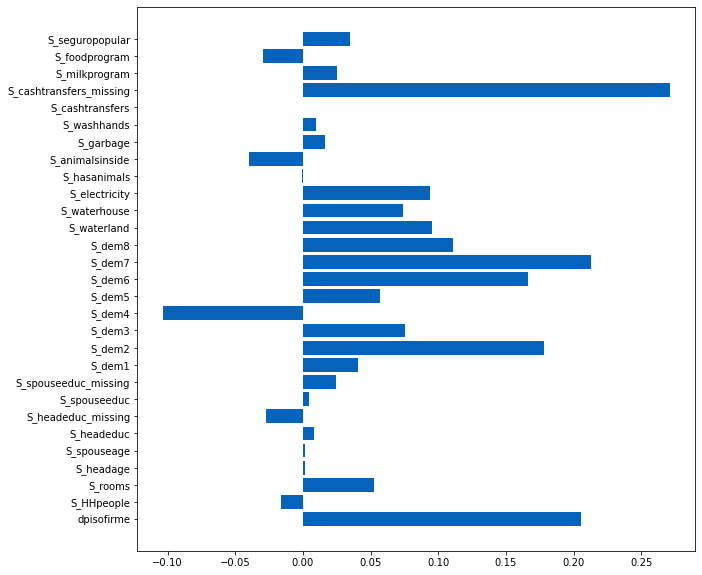

In [11]:
# Independent variables' names
features = ['dpisofirme', 
            'S_HHpeople', 'S_rooms', 'S_headage', 'S_spouseage', 'S_headeduc', 'S_headeduc_missing', 'S_spouseeduc', 'S_spouseeduc_missing', 'S_dem1', 'S_dem2', 'S_dem3', 'S_dem4', 'S_dem5', 'S_dem6', 'S_dem7', 'S_dem8', 
            'S_waterland', 'S_waterhouse', 'S_electricity', 'S_hasanimals', 'S_animalsinside', 'S_garbage', 'S_washhands', 'S_cashtransfers', 'S_cashtransfers_missing', 'S_milkprogram', 'S_foodprogram', 'S_seguropopular']

# Independent variables' values
X = households[features]

# Outcome
Y = households['S_shcementfloor']

# Fitting the model
model = LinearRegression().fit(X, Y)

# Printing the model coefficients
print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

# Plotting the model coefficients (feature importance)
plt.figure(figsize=(10, 10))
yticks = np.arange(len(X.columns))
plt.barh(yticks, model.coef_, color='#0563bb')
plt.yticks(yticks, labels=X.columns);

This plot (a.k.a. feature importance plot for a linear regression) tells us how much change is caused by a feature when we modify its input, but  it is not complete. Indeed, the coefficients could have very different scales, therefore comparing their magnitudes is akin to comparing apples with oranges! Hence, to properly evaluate the impact of a feature, we consider:
- Its effect on the output with a variation of the input.
- The distribution of the input for that feature.

For that, we resort to what is called a **partial dependence plot**: Given a certain feature $x_{i}$, this is a plot of the model considering feature $x_{i}$ and marginalizing all other features. In other words, it is the expectation on all other features of the model against the value of that feature. Considering the set of all features excluding $x_{i}$, $F$ :

<center> $ f_{x_{i}}(x_{i}) = E_{F}[f(x_{i}, F)]$ </center>

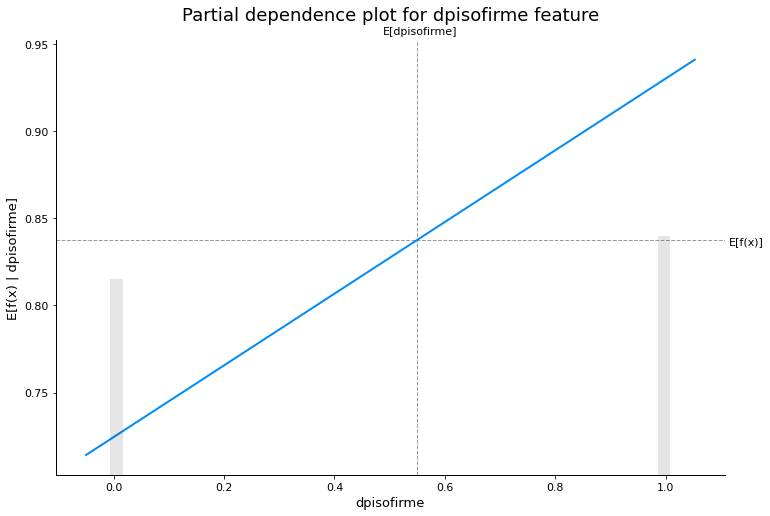

In [12]:
# Getting 100 random samples
X100 = shap.utils.sample(X, 100)

# Showing the partial dependence plot
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
shap.plots.partial_dependence("dpisofirme", model.predict, X100, ice=False, model_expected_value=True, feature_expected_value=True, ax=ax, show=False);
ax.set_title("Partial dependence plot for dpisofirme feature", fontsize=18);

The blue line represents the metric described above, but there is some additional information:

- The gray bars represent the distribution of the selected feature $x_{i}$ across samples. (Observe that there are only two possible values in this case since it is a categorical variable.)
- The horizontal dotted line corresponds to the expectation of the complete model.
- The vertical dotted line is the average value taken by feature $x_{i}$.

The intersection between the blue line and the two dotted lines is called the center of the partial dependence plot. 
For each sample, it is possible to plot the difference between the expectation of the complete model  and the prediction of the marginalized model for that sample. This is exactly the SHAP value for that feature of the model! 

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


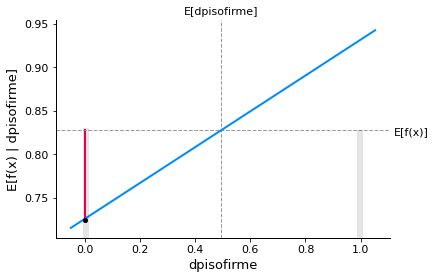

In [13]:
# Getting shap values
background = shap.maskers.Independent(X, max_samples=1000)
explainer = shap.Explainer(model, background)
shap_values = explainer(X)

# Making a standard partial dependence plot (showing SHAP value)
sample_ind = np.random.randint(len(X))
fig,ax = shap.partial_dependence_plot("dpisofirme", model.predict, X, model_expected_value=True, feature_expected_value=True, show=False, ice=False, shap_values=shap_values[sample_ind:sample_ind+1])

The red line represents the SHAP value. We observe that: 
- Given the categorical nature of the data, both possible values are quite far from their mean ( i.e which also corresponds to the center of the plot.)
- The farther we are from the center, the higher the SHAP value. 
- For `dpisofirme`, having a SHAP value near zero is highly unlikely. 

We can conclude that the closer the distribution of a feature is to the center of the partial dependence plot, the lower is the effect of that feature on the prediction. To strengthen this idea, we can show the same plot for `S_cashtransfers`which has a negligible regression coefficient:

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


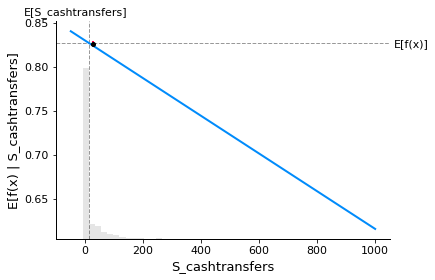

In [14]:
# Getting shap values
background = shap.maskers.Independent(X, max_samples=1000)
explainer = shap.Explainer(model, background)
shap_values = explainer(X)

# Making a standard partial dependence plot (showing SHAP value)
sample_ind = np.random.randint(len(X))
fig,ax = shap.partial_dependence_plot("S_cashtransfers", model.predict, X, model_expected_value=True, feature_expected_value=True, show=False, ice=False, shap_values=shap_values[sample_ind:sample_ind+1])

Instead of doing this for all features, we can directly compare them with the help of a waterfall plot ! THis will display the SHAP values of a given sample for each feature of the model. Let's plot it ! 

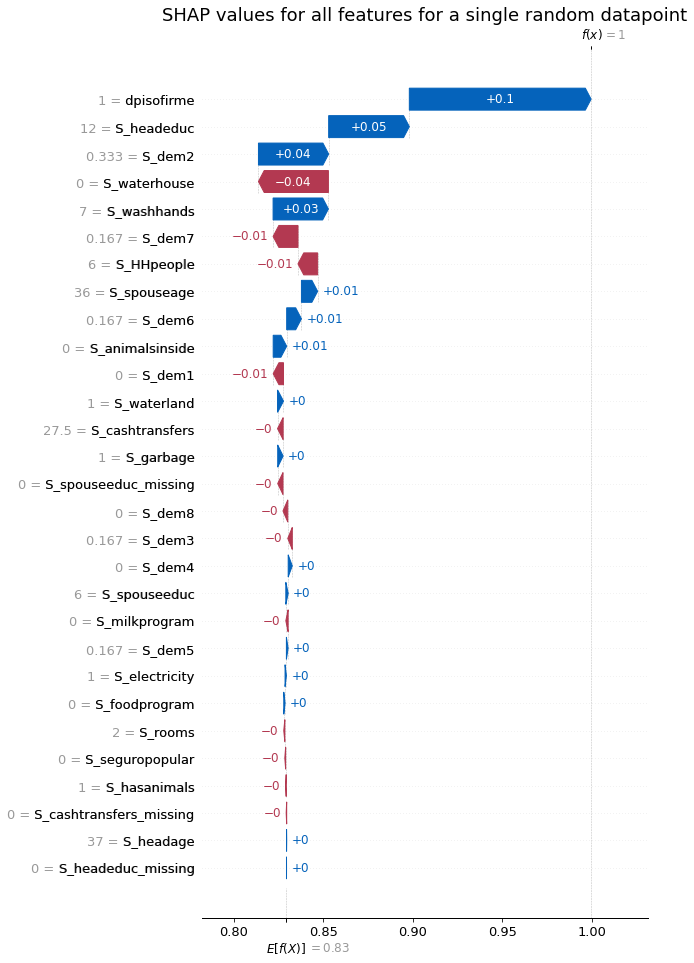

In [15]:
# Setting our colors
shap.plots.colors.blue_rgb = np.array(COLOR_RED_RGB)/255
shap.plots.colors.red_rgb = np.array(COLOR_BLUE_RGB)/255

# Plotting the shap value for a single sample
plt.figure()
shap.plots.waterfall(shap_values[sample_ind], max_display=len(X.columns), show=False)
plt.title("SHAP values for all features for a single random datapoint", fontsize=18);

We can see that for this datapoint, the SHAP value for dpisofirme is the highest, indicating that it has the most important impact on the prediction of that point. Nevertheless, we can see that there are other
variables that contributed significantly to the predicition, namely S_rooms that was not included in the analysis done by the researchers. (probably by mistake !)

However, we are only considering one datapoint here. We should try looking at the big picutre by plotting the distribution of these SHAP values, for each feature, across all datapoints. 

In [16]:
def get_cmap(color1, color2):
    """
    Generates a color map to create beeswarm plot with ours colors (red, blue)
    
    :param color1: first color
    :type color1: tuple
    :param color2: second color
    :type color2: tuple
    :return: generated color map
    :rtype: ListedColormap
    """
    
    Colors = [color1, color2]

    # Normalizing colors value
    Colors= [(R/255,G/255,B/255) for idx, (R,G,B) in enumerate(Colors)]
    n = 256

    # Starting with the creation of the gradient
    Color1= ListedColormap(Colors[0], name='Color1', N=None)
    Color2= ListedColormap(Colors[1], name='Color2', N=None)
    top = cm.get_cmap(Color1,128)
    bottom = cm.get_cmap(Color2,128)
    newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))

    mymin0 = newcolors[0][0]
    mymin1 = newcolors[0][1]
    mymin2 = newcolors[0][2]
    mymin3 = newcolors[0][3]
    mymax0 = newcolors[255][0]
    mymax1 = newcolors[255][1]
    mymax2 = newcolors[255][2]
    mymax3 = newcolors[255][3]

    GradientBlueRed= [np.linspace(mymin0, mymax0,  n),
                       np.linspace(mymin1, mymax1,  n),
                       np.linspace(mymin2, mymax2,  n),
                       np.linspace(mymin3, mymax3,  n)]

    GradientBlueRed_res =np.transpose(GradientBlueRed)

    return ListedColormap(GradientBlueRed_res, name='BlueRed')

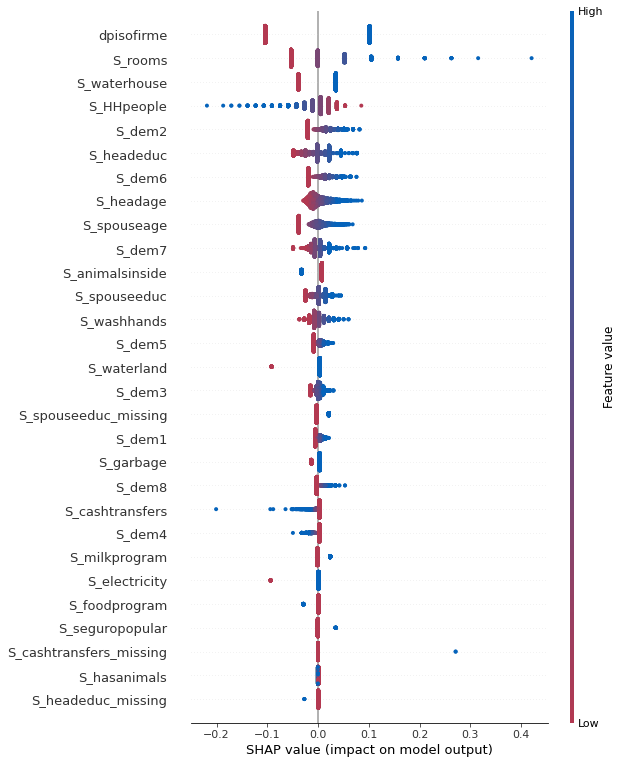

In [17]:
# Plotting all shap values
plt.figure()
shap.plots.beeswarm(shap_values, max_display=len(X.columns), show = False)

# Getting the cmap
cmap = get_cmap(COLOR_RED_RGB, COLOR_BLUE_RGB)

# Changing the colormap
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(cmap)

This plot shows the distribution of the SHAP values for each feature. There are several observations we can make: 
 1. The height of the bar for each feature is proportonal to the number of samples that have that SHAP value.
 2. We can see that, starting from the bottom, most of the features have their SHAP values centered around zero, with almost zero variance, which means that they do not contribute significantly to the prediction.
 3. On the other hand, for dpisofirme, since, it is categorical, there are only two possibilities, for the SHAP values, which are pretty high since the distribution has high variance around its mean. This shows that dpisofirme, had a significant impact on the outcome of the prediction.
 4. From this, we can see that there are other variables with significant impact such as `S_waterhouse`and `S_rooms`. 
 5. Additionally, some variables also have high SHAP values for certain datapoints, but these correspond to outliers and do not reflect the distribution of the SHAP values.

## _Step 4:_ Using different models to analyse author's conclusions

### Table 4: Cement floor coverage measures on program dummy

Firstly we will concentrate our attention on _Table 4_ of the paper. We know it well because of the previous replication done on that table, but we want to see if the results still hold from the new perspective of SHAP values that we presented before. 
To be more specific, we will use three different methods to assess the impact of each feature, namely:

- A Linear Regression model
- A Decision Tree classifier
- A Random Forest classifier

We will use SHAP values to assess the predictive power of each features in the Linear Regression model and in the Random Forest classifier, and we will plot the final structure of the decision tree to see when the split occurs and compute the related information gain.

**Note**: In the paper, the authors used three different regression models to assess the impact of Piso Firme program. For the last one, as mentioned, they forgot to include the variable `S_rooms`. We will use this third model, including this variable in the prediction. In particular, we will use as features the ones declared in **Step 3**.

### Substep 4.1: Simplifying the visualization

We've seen the power of SHAP's beeswarm plot, but, as you may have noticed, at first glance it's not easy to understand what is going on. 
SHAP offers also another plot, called `bar` that, for each feature, offers a visualization of its SHAP absolute value. We thought about using this plot to better visualize the result, but there's a problem: we don't know, with this kind of plot, if one feature contribution is positive or negative with respect to the outcome.

We decided, then, to create our own plot, starting from the SHAP values we obtain. This <a href="https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d">article</a> came us in handy for this purpose.

In [18]:
def shap_plot(df_shap,df, ax, outcome):
    # Making a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determining the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    
    # Making a dataframe: column 1 is the feature, and column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0, COLOR_BLUE, COLOR_RED)
    
    # Plotting it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, legend=False, ax = ax)
    ax.set_xlabel("SHAP Value (Blue = Positive Impact)")

### Substep 4.2: Linear regression

In this step we create a Linear Regression model, and we apply it to each outcome. We compute the SHAP values for each datapoint, and we average them in order to plot them. Do the authors result still hold under these conditions?

In [19]:
def build_shap_plot(df, outcome, features, ax, model_, explainer_):
    """
    Plotting the shap values for an outcome given the model and the explainer.
    
    :param df: dataframe from which taking the data
    :type df: pandas.Dataframe
    :param outcome: the outcome to pick to create the plot
    :type outcome: str
    :param features: the features to fit the model
    :type features: numpy.ndarray
    :param ax: specify where to plot
    :type ax: AxesSubplot
    :param model_: sklearn model to fit
    :type model_: any
    :param explainer_: explainer to compute SHAP values
    :type explainer_: any
    :return: fitted model
    :rtype: any
    """
    
    X = df[features]
    Y = df[outcome]
    
    # Fitting the model
    model = model_.fit(X, Y)
    
    # TreeExplainer needs to be instantiated in a different way
    if explainer_ == shap.TreeExplainer:
        explainer = explainer_(model)
    else:
        explainer = explainer_(model, X)
        
    # Computing SHAP values
    shap_values = explainer.shap_values(X)

    # Plotting it
    shap_plot(shap_values, X, ax, outcome)
    
    return model

def build_shap_subplots(rows, cols, df, features, outcomes, title, model_, explainer_):
    """
    Plotting the shap values for all outcomes in a grid given the model and the explainer
    
    :param rows: number of rows in the grid
    :type: int
    :param cols: number of cols in the grid
    :type cols: int
    :param df: dataframe from which taking the data
    :type df: pandas.Dataframe
    :param features: the features to fit the model
    :type features: numpy.ndarray
    :param outcomes: the outcomes to create the plot
    :type outcome: numpy.ndarray
    :param title: the title of the plot grid
    :type title: str
    :param model_: sklearn model to fit
    :type model_: any
    :param explainer_: explainer to compute SHAP values
    :type explainer_: any
    :return: fitted models
    :rtype: any
    """
    
    # Creating the grid
    fig, axs = plt.subplots(rows, cols, figsize = (20, 20), constrained_layout = True, sharex = True)
    
    models = []

    for k, outcome in enumerate(outcomes):
        i= k // 3
        j= k % 3
        
        # Building the shap value for an outcome
        model = build_shap_plot(households, outcome, features, axs[i, j], model_, explainer_)
        models.append(model)
        
        axs[i, j].set_title(f'Outcome: {outcome}')

    # Showing x ticks
    for j in range(3):
        axs[0, j].xaxis.set_tick_params(labelbottom = True)
    
    # Removing axes not used
    for i, ax in enumerate(axs.flat):
        if i >= len(outcomes):
            fig.delaxes(ax)

    # Setting the title
    fig.suptitle(title, fontsize = 16);
    
    return models

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


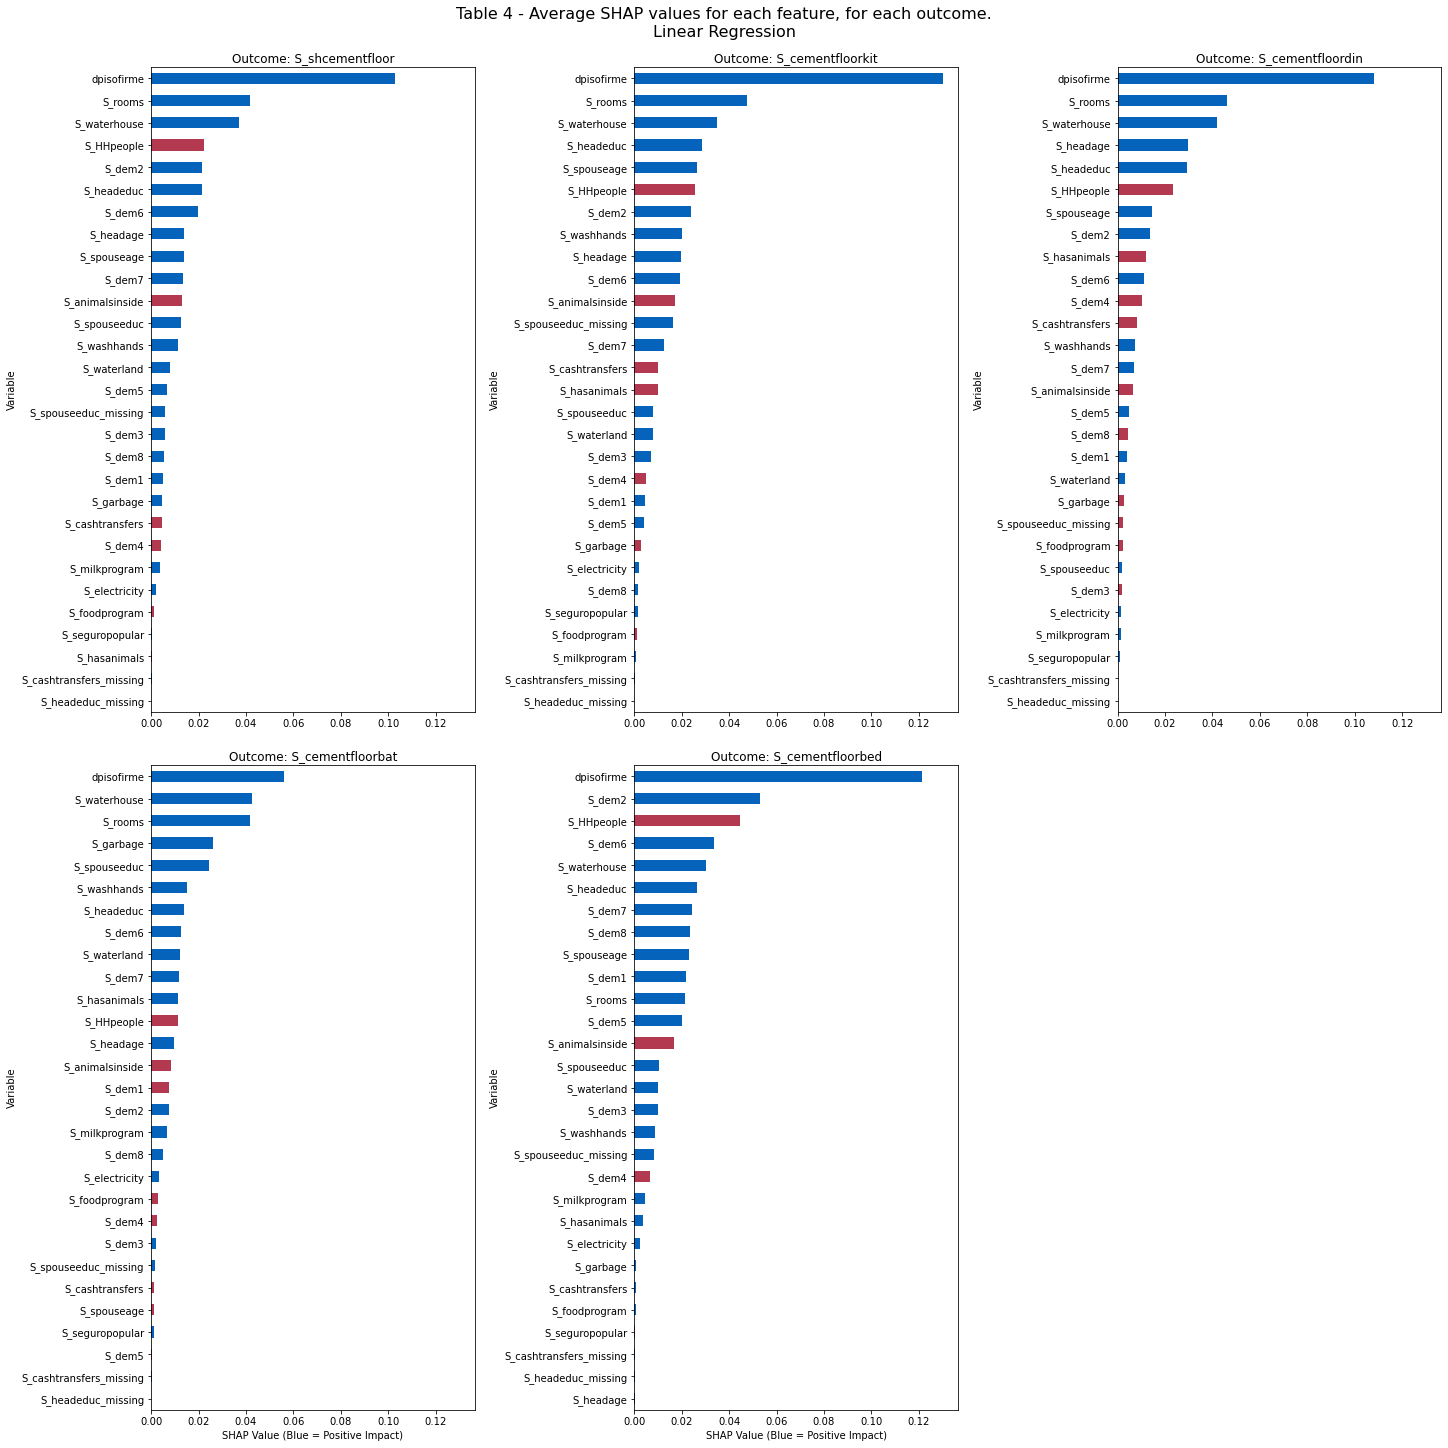

In [20]:
# Setting the outcomes used in Table 4 of the paper
outcomes_table_4 = ['S_shcementfloor', 'S_cementfloorkit', 'S_cementfloordin', 'S_cementfloorbat', 'S_cementfloorbed']


linear_models = build_shap_subplots(2, 3, households, features, outcomes_table_4, 
                                                 'Table 4 - Average SHAP values for each feature, for each outcome.\nLinear Regression',
                                                 LinearRegression(), shap.LinearExplainer)

### Substep 4.3: Linear regression - results

The results reported in the paper still hold, however, there's something that needs to be noticed:
- The variable `S_rooms` (number of rooms in the house) has a noticeable positive correlation with these outcomes: `S_cementfloorkit`, `S_cementfloordin`, `S_cementfloorbat`, but has little to no correlation with the outcome `S_cementfloorbed`. Do you notice a pattern here? Well... We do! The rooms that are correlated with the outcome are all common spaces (kitchen, dining room, bathtroom), while the bedroom, which is not a common space, is not correlated, in terms of "cementification" of the floor, with `S_rooms`. This could be explained: since the amount of cement each household could receive was enought to cover up to 50 square meters of floor, if a household had many rooms they would have had, probably, more than one bedroom. So, how would they decide which room to put cement in? Of course the fairest choice is to put cement in a common space, and not in one of the bedrooms. So the more rooms a household had, the more likely was to use Piso Firme to put cement in a common room and not in one bedroom... _Interesting_

- For the outcome variable `S_cementfloorbat` we notice that `S_waterhouse` (dummy variable that represents whether there was water connection inside the house) has almost the same (positive) impact of `dpisofirme`. Of course, this makes total sense: if a house hasn't water connection, it's unlikely that the house has a proper bathroom, so the household decided to put cement in a proper room.

- For the outcome variable `S_cementfloorbed` it is possible to make some more considerations: we notice that `S_dem2` and `S_dem6`, namely the number of males and females between 6 and 17 years in the family, in 2005, have a positive correlation with the outcome, while `S_HHpeople` (number of household members) correlation with `S_cementfloorbed` is hugely negative. What is going on? Let's start with `S_HHpeople`: normally, the more households members, the more bedrooms there are in a house. As we said in the first point of this analysis, when a house has more than one bedroom, it's more likely the family decided to put cement in a common space, in a "democratic" fashion. __But__ why, then, the correlation with the children-related variables? Let's not forget that, while the survey was conducted in 2005, Piso Firme started to take place (for the treatment group) in 2000. This means that, in 2000, `S_dem2` and `S_dem6` represented the number of children between 1 and 12 years old in the house. From a parent perspective, it makes total sense to put cement in the bedroom (or in children's bedroom, if there's more than one bedroom)! So if, when Piso Firme was offered to the household, children were present, their parents would decide to put cement in their bedroom to ensure them better life conditions.

__In conclusion__: this is only the first analysis of this extension, but we understood many things: first of all Mexican people, at least from this perspective, think in a "democratic" way: if only one part of the family could live better having cement floor in its bedroom, well, that's not fair and so cement was put in a common space of the house.
Secondly, this "democratic" way of thinking doesn't apply to the situation in which there are children in the family, that are privileged in the choice of where to put cement. It would be nice to interview again the households that took part in the 2005 survey to assess whether our conclusion are well thought, but unfortunately this is not possible. However, it's still wonderful to see how many considerations can be made with a "simple" dataset like the one we are analysing.

### Substep 4.4 : Decision Trees

We now turn our attention to decision tree models. These models use either continous (Decision Tree Regressor) or discrete (Decision Tree Classifier) predictors to generate an output. More specifically, in the case of a Decision Tree Regressor, we can try to understand how the tree is built, i.e how the splitting is done for each level, and how a prediction is made. We decide to use a Decision Tree Regressor because the output and some features are continuous.

- Splitting: To perform a split, for each feature, there are two possibilities. 
    1. The feature is continuous: in this case the model picks two consecutive values (among sorted samples) and pretends to split the data at the mean of these two values. It does it for all the values the feature can assume.
    2. The feature is discrete: in this case the model pretends to perform a split at each of the feature's N sorted values.
    
The final choice is determined by the variable and value that provide the best split. 

- To assess the quality of a split, the model computes the weighted mean squared error accross the resulting subsets, considering as prediction the mean of the outcomes in the training set. This value should be the smallest accross all possible splits. 

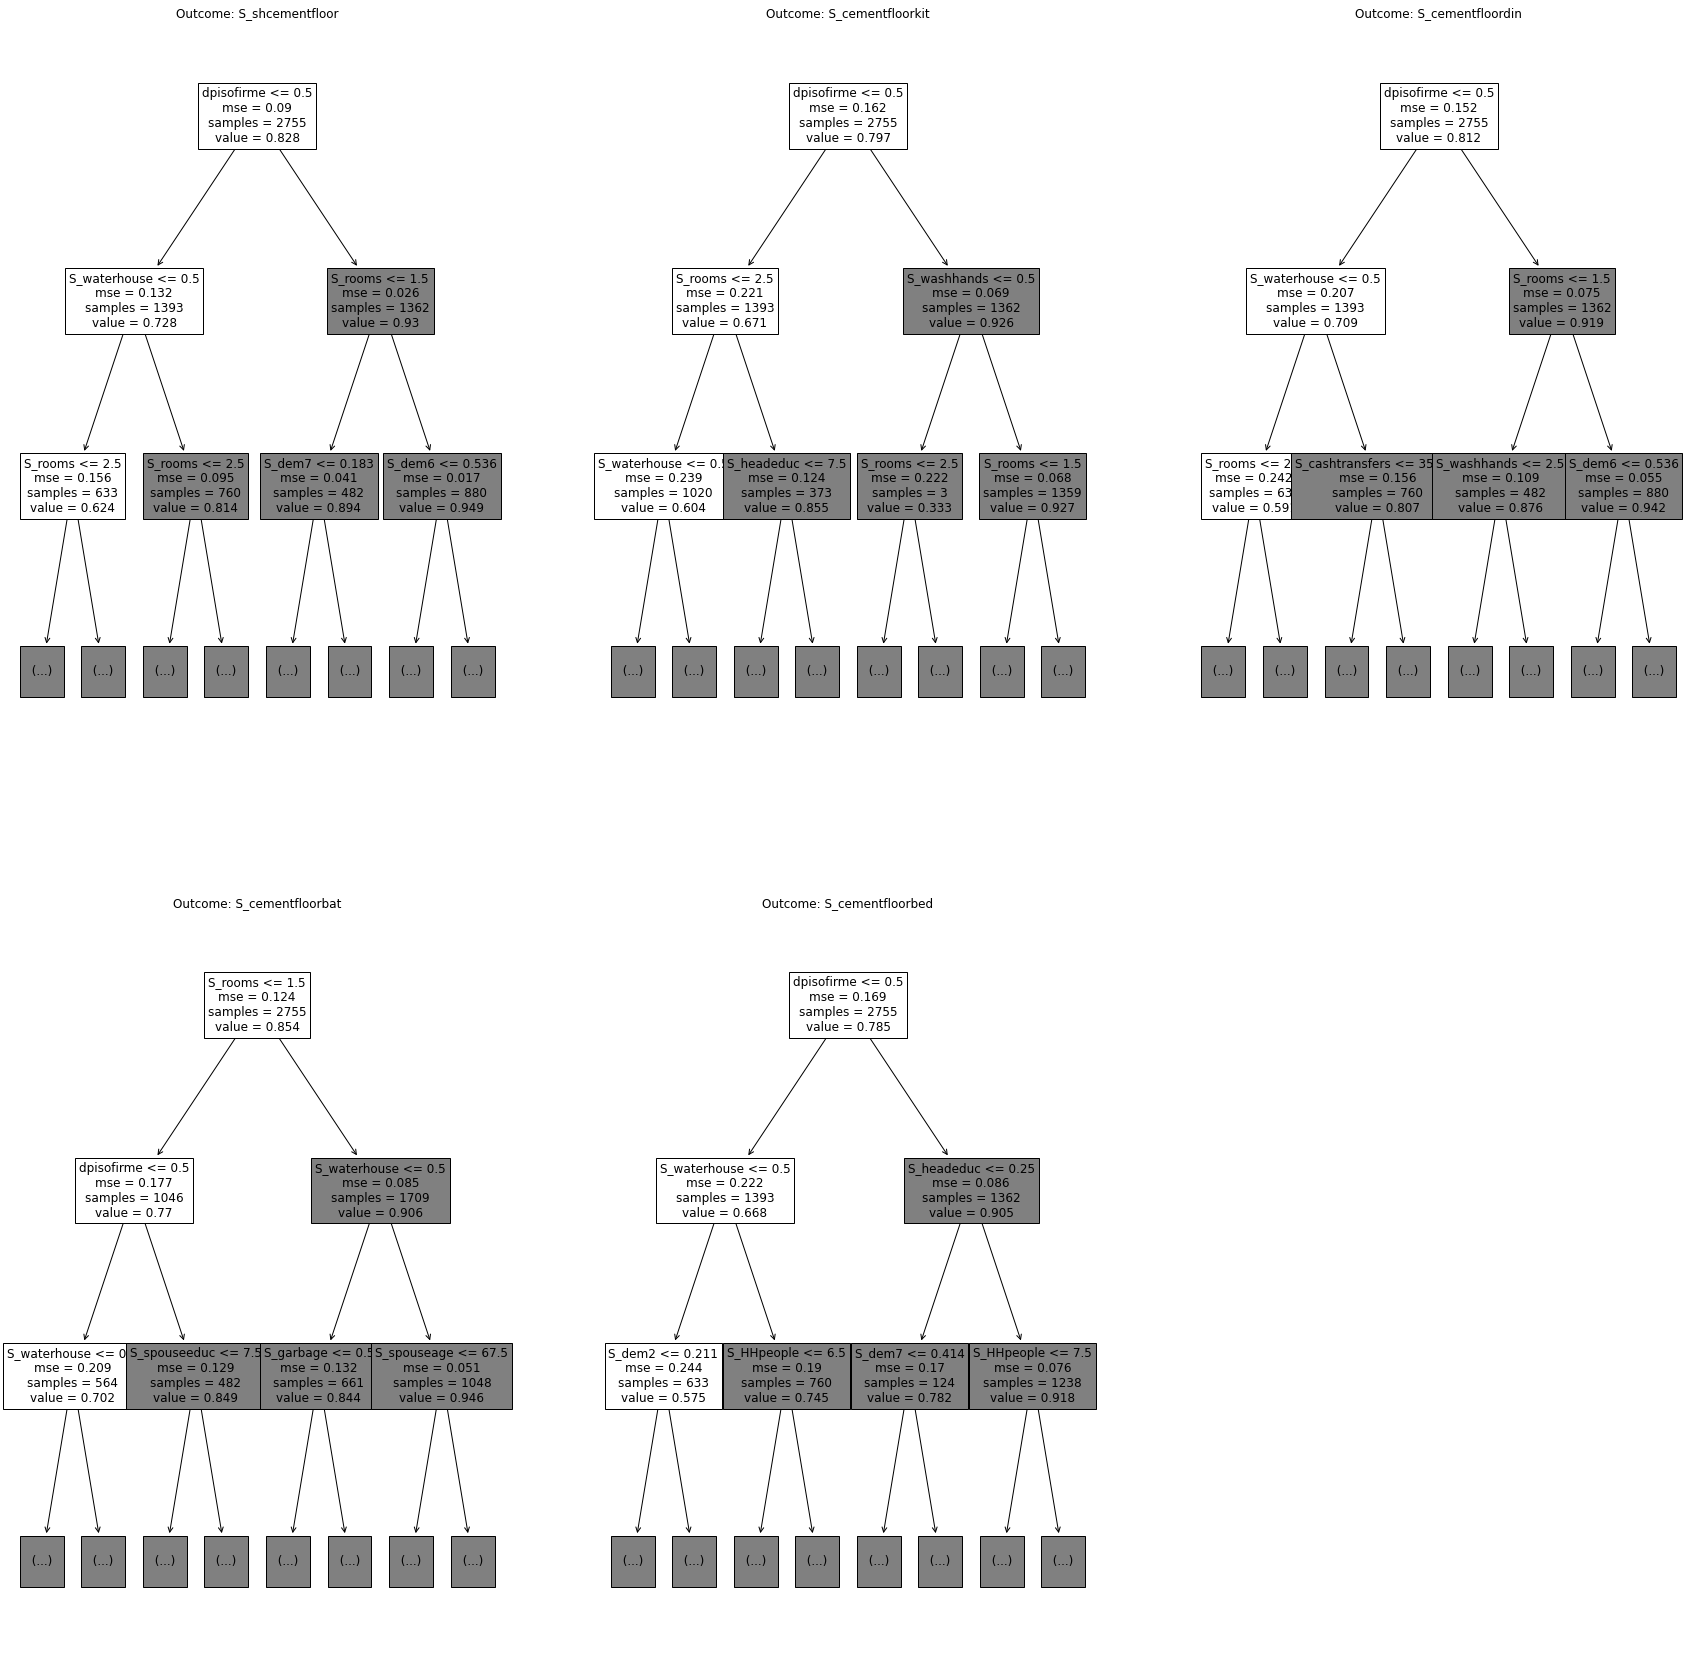

In [21]:
def decision_tree_model(df, outcome, features, ax):
    """
    Builds and plots the decision tree for the outcome of given features.
    
    :param df: the dataframe
    :type df: pandas.DataFrame
    :param outcome: the dependent variable
    :type outcome: str
    :param featues: the independent variables
    :type featues: numpy.ndarray
    :param ax: specify where to plot
    :type ax: AxesSubplot
    """
    
    X = df[features]
    Y = df[outcome]
    
    # Fitting the model
    model = DecisionTreeRegressor().fit(X, Y)
    
    # Plotting the tree
    plot_tree(model, max_depth = 2, ax = ax, feature_names = features, fontsize = 12)


# Creating the grid
fig, axs = plt.subplots(2,3, figsize = (30, 30))

for k, outcome in enumerate(outcomes_table_4):
    i= k // 3
    j= k % 3
    
    # Plotting the tree for an outcome
    decision_tree_model(households, outcome, features, axs[i, j])
    axs[i, j].set_title(f'Outcome: {outcome}')
    
# Removing axes not used
fig.delaxes(axs[1, 2])

Before making assumptions, let's plot the SHAP values of the five trees.

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


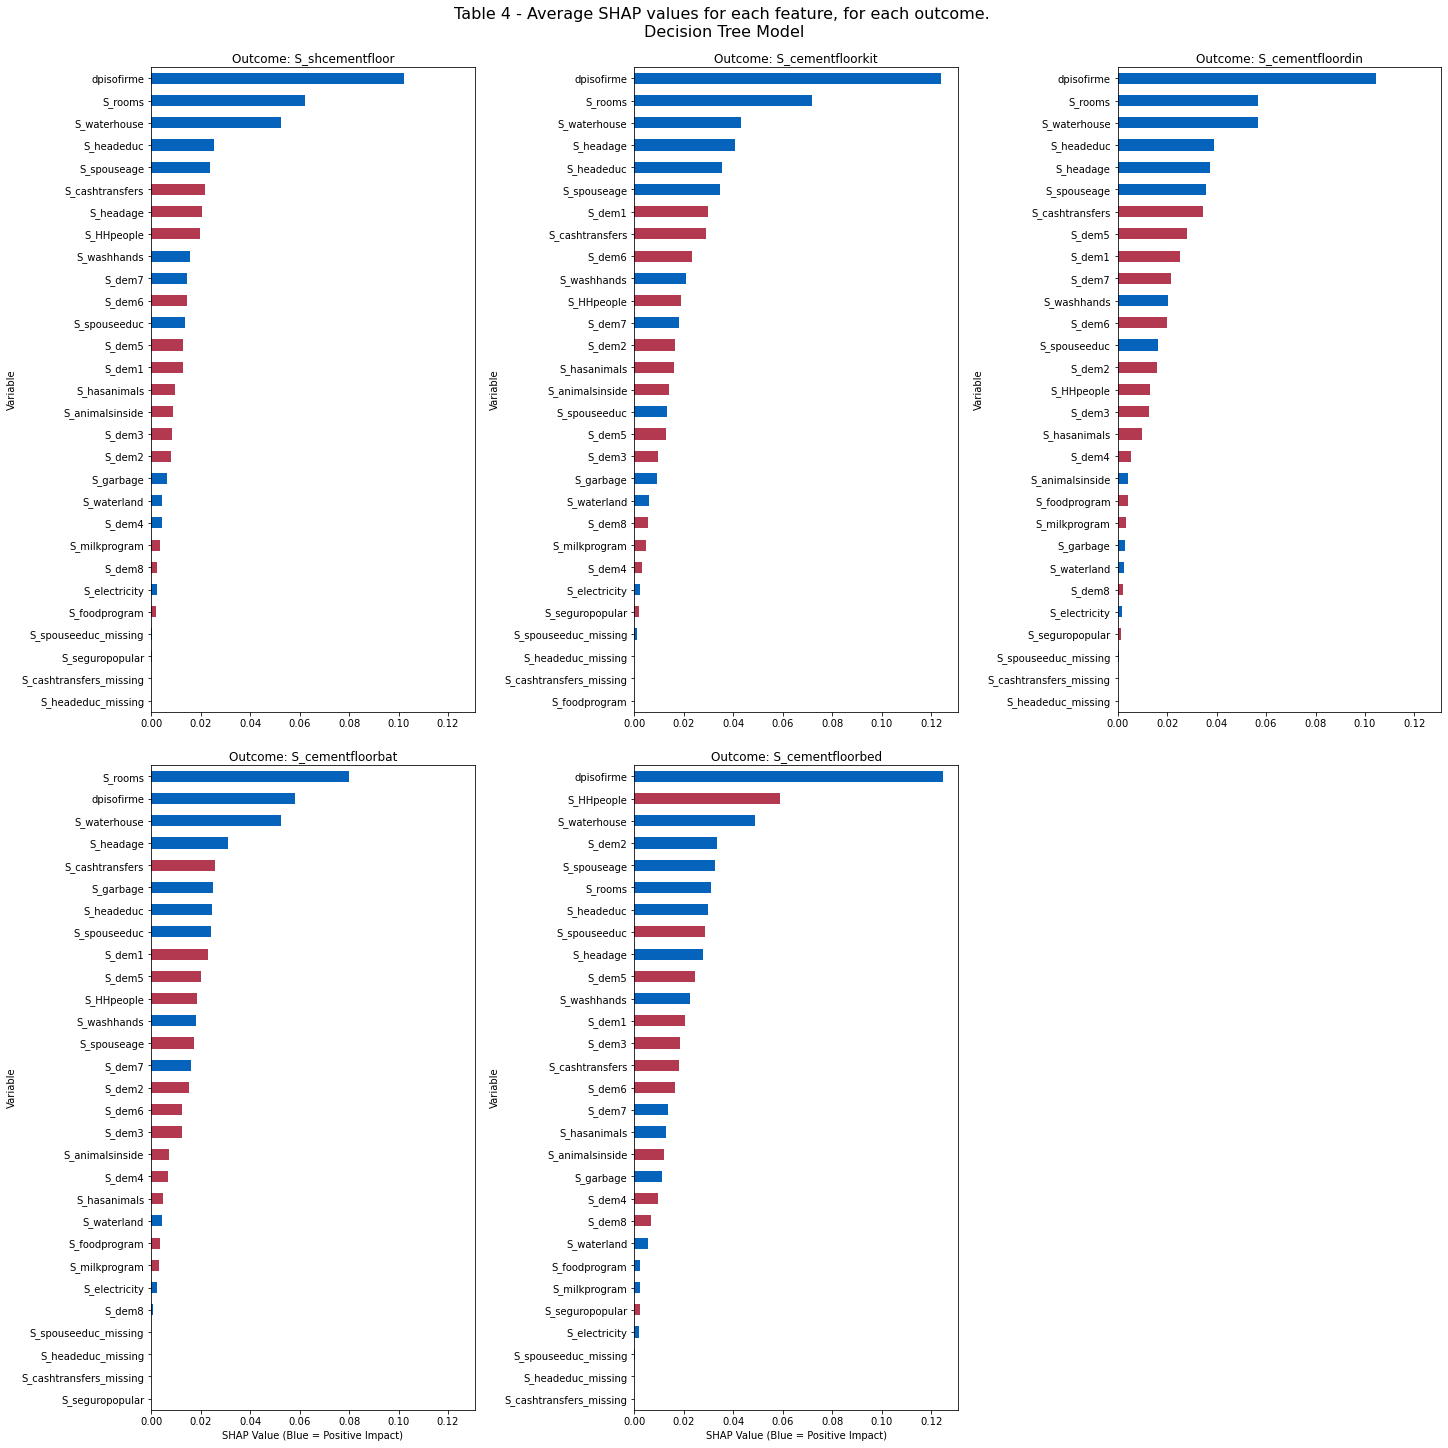

In [22]:
shap_decision_tree_models = build_shap_subplots(2, 3, households, features, outcomes_table_4, 
                                                 'Table 4 - Average SHAP values for each feature, for each outcome. \nDecision Tree Model',
                                                 DecisionTreeRegressor(), shap.TreeExplainer)

The models also return a value, called feature importance, for each feature. This number, as you guessed, represents the importance of each feature for the final prediction. It must be mentioned that impurity-based feature importances (the ones computed by sklearn, that we plot), can be misleading for high cardinality features (many unique values). This is exactly our case for some variables, so we should take the feature importances plots with a grain of salt.

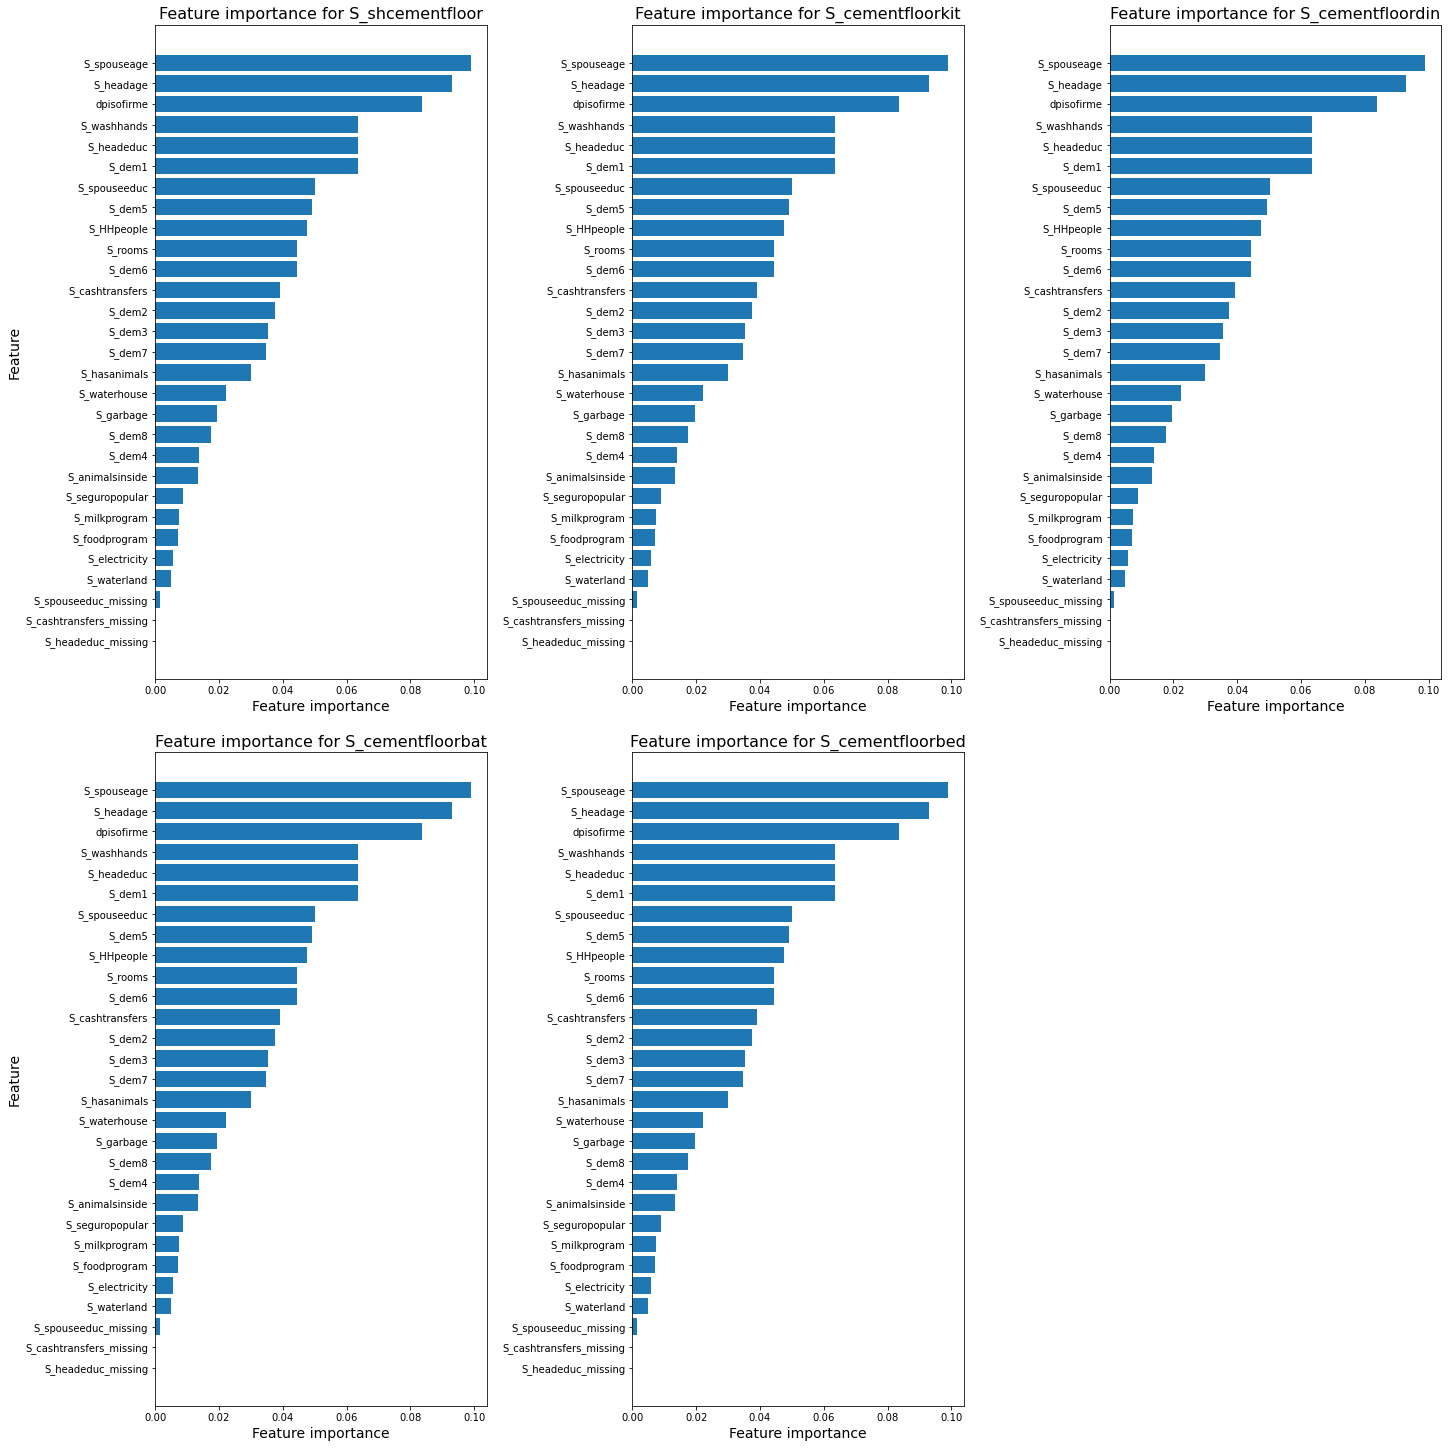

In [23]:
def plot_feature_importance(models, features, outcomes):
    """
    Plotting the feature importance for all outcomes with given features.
    
    :param models: fitted models
    :type models: any
    :param features: the independent variables
    :type features: numpy.ndarray
    :param outcomes: the outcomes
    :type outcomes: numpy.ndarray
    """
    
    # Creating the grid
    fig, axs = plt.subplots(2,3, figsize = (20, 20), sharex=True, constrained_layout=True)

    for k, outcome in enumerate(outcomes):
        i = k // 3
        j = k % 3
        
        # Getting the feature importances
        feature_importance = models[k].feature_importances_
        
        # Sorting them before plotting
        importance_dict = dict(zip(features, feature_importance))
        importance_dict = {k: v for k, v in sorted(importance_dict.items(), key=lambda item: item[1])}
    
        # Plotting the sorted feature importances
        axs[i, j].barh(yticks, list(importance_dict.values()))
        axs[i, j].set_title(f"Feature importance for {outcome}", fontsize=16)
        axs[i, j].set_xlabel('Feature importance', fontsize=14)
        axs[i, j].set_yticks(yticks)
        axs[i, j].set_yticklabels(list(importance_dict.keys()))

        if j == 0:
            axs[i, j].set_ylabel('Feature', fontsize=14)

    # Showing x ticks
    for j in range(3):
        axs[0, j].xaxis.set_tick_params(labelbottom = True)

    # Removing axes not used
    fig.delaxes(axs[1, 2])

plot_feature_importance(shap_decision_tree_models, X.columns, outcomes_table_4)

### Substep 4.4: Decision trees -  results

To estimate the impact of each feature, we consider when the split occurs: from what we explained before it is clear that the tree will try to split at first on the features with the highest predictive value. We also take into account the two plots (SHAP values and feature importance).
From this analysis we notice:

- For the outcomes `S_shcementfloor`, `S_cementfloorkit` and `S_cementfloordin` we observe results which are comparable to the ones obtained before. We notice that the first feature on which a split occurs is, indeed, `dpisofirme`, which is also the most important feature according to the previous plot. This confirms the authors claims and, in general, the importance of the program. We also notice that the variables `S_rooms` and `S_waterhouse` play a significant role in the decision, exactly as we stated before with the regression. This brings us to the same conclusions that we made for the previous step. There's something unexpected that needs to be mentioned, though: it seems that the age of the "head" of the household and the one of his spouse play an important role too, but it is hard to understand why, and this might also be a fake correlation, due to the fact that there are many unique values for these feature. Indeed, we don't notice the same importance in the SHAP values plot

- For the outcome `S_cementfloorbat` the first variable on which the split occurs is `S_rooms`, implying that it has more predictive power, at least for this model, than the program-related variable `dpisofirme`. This is comparable to what we observed with the linear regression: it is true that in the previous model the SHAP value of `dpisofirme` was slightly higher than the one of `S_rooms` and `S_waterhouse` but the difference was not significant. This means that our observations for this particular outcome can still be considered valid. Again: the feature importance plot shows a situation which is different from the one we are describing, but again, with respect to variables with high unique values in them. Also, the SHAP values plot confirms our analysis.

- For the outcome `S_cementfloorbed` the situation is pretty different from the one observed before: it is true that the first split occurs on the program dummy variable, but we don't observe anymore the variables related to the number of children. This shows that our assumption made about this outcome is not really supported by the data. It could still be true in some parts though, at least with respect to `S_HHpeople` that we can observe in the third layer of the tree. This means, as we said, that the more people live in the house, the higher was the chance to choose to put cement in a common room and not in a bedroom.

In conclusion, we achieved more or less the same results as before. Our previous analysis on mexican people can still be considered valid, at least with respect to the decision related to the room in which the cement was put. We can state again that this analysis is more in depth and complete than the one provided by the authors, as it sheds light on several correlations that are not necessarly reported in the paper. We cannot deny the impact of Piso Firme on the considered outcomes, but it should be put against the contribution of other factors, described by the other features, that we tried to underline. 

### Substep 4.5: Random forest and SHAP values

As last analysis on this table, we would like to bring our attention to ensemble methods. In particular, we use a Random Forest model, which is an estimator that makes prediction averaging the results obtained from several decision trees (20 in our case, with a maximum depth of 10). Each tree is trained on a subset of features and samples of our dataset. Since we can't visualize all the trees for each outcome, we use again SHAP values to explain the results. For completeness we also report the feature importance plot for this model, but, again, in some cases it might not be very representative of reality.

invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in true_divide


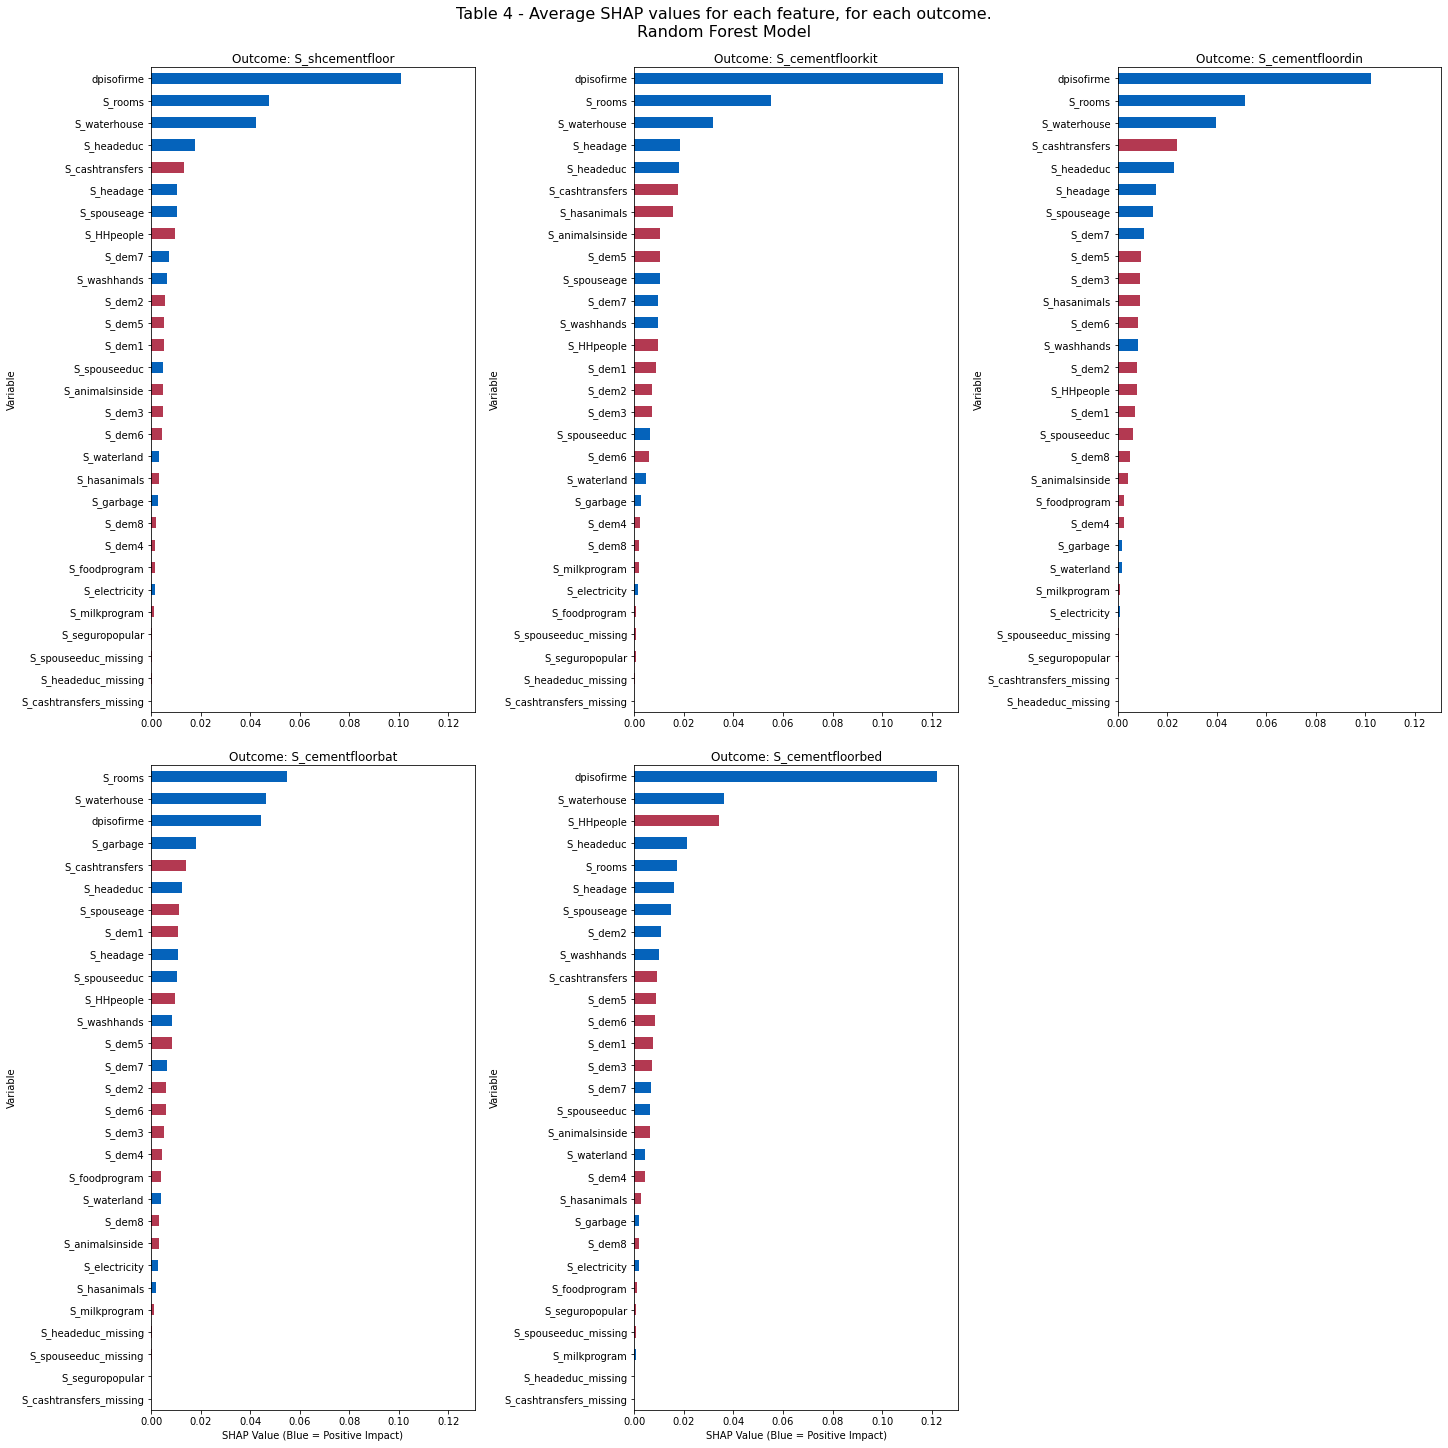

In [24]:
shap_random_forest_models = build_shap_subplots(2, 3, households, features, outcomes_table_4, 
                                                 'Table 4 - Average SHAP values for each feature, for each outcome.\nRandom Forest Model',
                                                  RandomForestRegressor(max_depth=10, random_state=0, n_estimators = 20), shap.TreeExplainer)

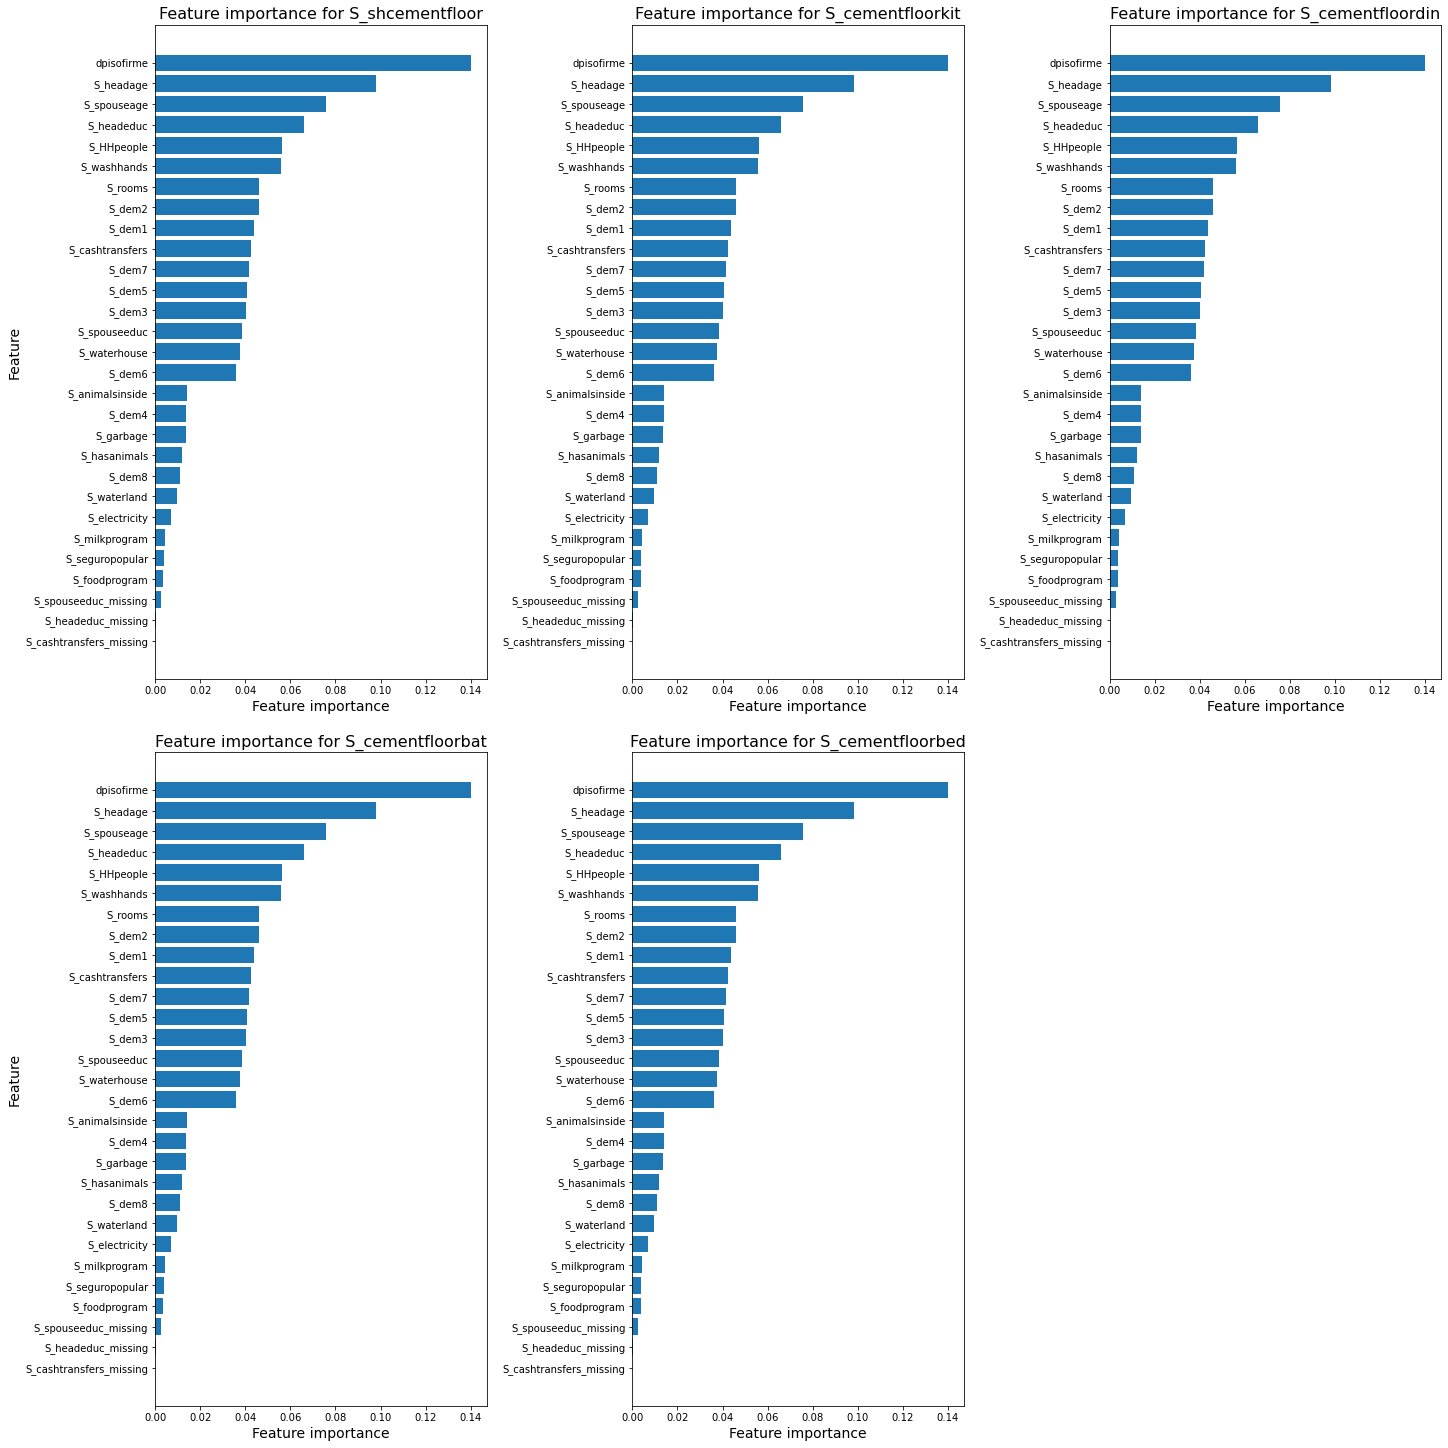

In [25]:
plot_feature_importance(shap_random_forest_models, features, outcomes_table_4)

### Substep 4.6: Random Forest - results

Taking into account only the SHAP values plot, and not the feature importance one for the reasons we stated before, we notice again that `dpisofirme` has a considerable positive correlation with all the outcomes, but again , also `S_room` plays an important role, when we consider a common room, while it is basically absent when the outcome is `S_cementfloorbed` (cement floor in bedrooms). This might confirm our previous hypothesis: the higher the number of rooms, the higher the probability that people who were offered the program decided to use their bonus to put cement in a common room. This, as we tried to explain in **substep 4.3**, makes sense. Please refer to that point for a more detailed explaination.

For `S_cementfloorbat` we notice a result which is similar to the one reported by the decision tree used before. In particular, we notice that `S_rooms` and `S_waterhouse` play a role which is more important than the one played by `dpisofirme`, although it is undeniable that the program had an important impact too. So, how can we explain this result? Again, for `S_rooms` the explanation is exaclty the same as before: bathrooms are common rooms and it is more likely to put cement in a common room when there is a high number of rooms in the house. Moreover, talking about `S_waterhouse`, as we stated previously, it makes sense that it is more important than the dummy variable related to Piso Firme for this particular outcome, since no matter how many programs are offered to you, if you don't have water in your house it is unlikely for you to have a bathroom. Maybe, then, it would have been more reasonable to invest in water connections together with the program. 

# LIME Values

While the insight given by the SHAP values is valuable and allows us to assess the proposed models and their variants efficiently on both a local and global scale, it would be interesting to use another approach of assessment to confirm or infirm the consistency of our results. For that purpose, we make use of __LIME__ (Local Interpretable Model-Agnostic Explanations). 

These values, unlike SHAP values, only offer a _local_ explanation of a single prediction by generating and learning an easily interpretable model around the corresponding datapoint. In other words, it breaks down a prediction in a simpler model built from the vincinity (newly generated samples) of the considered datapoint.

Here is a more visual explanation of the process, for a classifier on a 2-D plane: 
<center><img src="img/local-model.jpg" width=426 height=258 /></center>

On this image , we can see: 
- The global model, defined by the blue and red areas, which is rather complex and has a non-linear boundary between the two classes it tries to predict. 
- A local approximation of the model that is learned with generated datapoints surrounding (and including) the bold red cross, which corresponds here to the dotted line. The closer a newly generated datapoint is to the original, the higher its weight is when training the local approximation. This is represented by the relative size of the datapoints.

Clearly, the local approximation of the model  is easier to interpret, and is locally accurate. 
This is exactly what LIME does ! 
Let us apply this technique to our dataset for some randomly sampled datapoints.

In [26]:
def lime_explainer(features,categorical, outcome, data):
    """
    Returns an explainer given a training set, its defining features and 
    a desired outcome.
    
    :param features: features of the model.
    :type features: numpy.ndarray
    :param categorical: categorical features of 'features'.
    :type categorical: numpy.ndarray
    :param outcome: desired outcome.
    :type outcome: str
    :param data: training data of the model
    :type data: pandas.DataFrame
    :return explainer: Lime explainer.
    :rtype: LimeTabularExplainer
    """
    explainer = lime_tabular.LimeTabularExplainer(data.to_numpy(),
                                                  feature_names=features,
                                                class_names = outcome,
                                                  categorical_features=categorical,
                                                mode='regression')
    return explainer

In [27]:
def plot_lime(ax, exp_list, title):
    """
    Helper function for plotting.
    
    :param ax:  ax to plot on.
    :type ax: AxesSubplot
    :param exp_list: (name,value) list of lime values.
    :type exp_list: list
    :param title: Title given to plot
    :type title: str
    :return: updated ax.
    :rtype: AxesSubplot

    """
    
    vals = [x[1] for x in exp_list]
    names = [x[0] for x in exp_list]
    vals.reverse()
    names.reverse()
    colors = [COLOR_BLUE if x > 0 else COLOR_RED for x in vals]
    pos = np.arange(len(exp_list)) + .5
    ax.barh(pos, vals, align='center', color=colors)
    ax.set_yticks(pos)
    ax.set_yticklabels(names)
    ax.set_title(title)
    return ax

In [28]:
#Some useful definitions 
FEATURES_CATEGORICAL = ['dpisofirme', 
            'S_headeduc_missing',  
            'S_spouseeduc_missing',  
            'S_waterland', 'S_waterhouse', 'S_electricity', 'S_hasanimals', 'S_animalsinside', 
                        'S_garbage', 
            'S_cashtransfers_missing', 'S_milkprogram', 'S_foodprogram', 'S_seguropopular']
HOUSEHOLD_FEATURES = households[features]


In [29]:
def explain_random_datapoints(outcome,model_type='Linear',seed_points=0):
    """
    Provides a lime explanation for 3 randomly generated datapoints, according to the given seed.
    
    :param outcome: outcome of model to explain
    :type outcome: str
    :param model_type: type of model (linear, decision tree, random forest)
    :type model_type: str
    :param seed_points: For consistency of randomness accross runs of function
    :type seed_points: int
    """
    
    household_target = households[outcome]
    household_train_X,  household_test_X, household_train_Y, household_test_Y = train_test_split(HOUSEHOLD_FEATURES,household_target,random_state=0)
    
    # Selecting the type of model we wish to explain
    if model_type == 'linear':
        model = LinearRegression().fit(household_train_X, household_train_Y)
    elif model_type == 'decision tree':
        model = DecisionTreeRegressor().fit(household_train_X, household_train_Y)
    elif model_type == 'random forest':
        model = RandomForestRegressor(max_depth=10, random_state=0, n_estimators = 20).fit(household_train_X, household_train_Y)
    
    #Defning explainer with lime_explainer
    explainer = lime_explainer(features,FEATURES_CATEGORICAL, outcome,household_train_X)
    
    # For consistent randomness
    np.random.seed(seed_points)
    rand_points = np.random.randint(0,len(household_test_X),3)
    
    fig, axs = plt.subplots(1,3,figsize=(20,10))
    for i, rand_point in enumerate(rand_points):
        print(household_test_X.iloc())
        exp = explainer.explain_instance(household_test_X.iloc[rand_point], 
             model.predict, num_features=len(features))
        exp_list = exp.as_list()
        plot_lime(axs[i],exp_list,"Local explanation of random point %d" % (i+1))
    
    fig.suptitle("Local explanations of %s model for outcome _S_shcementfloor" % model_type, fontsize=14)
    plt.tight_layout()
    

### Share of cement floors (S_shcementfloor)

To have an idea of how locally intepretable each model is, we will plot the LIME values of 3 random datapoints for each model type (Linear, Decision Tree, Random Forest). 

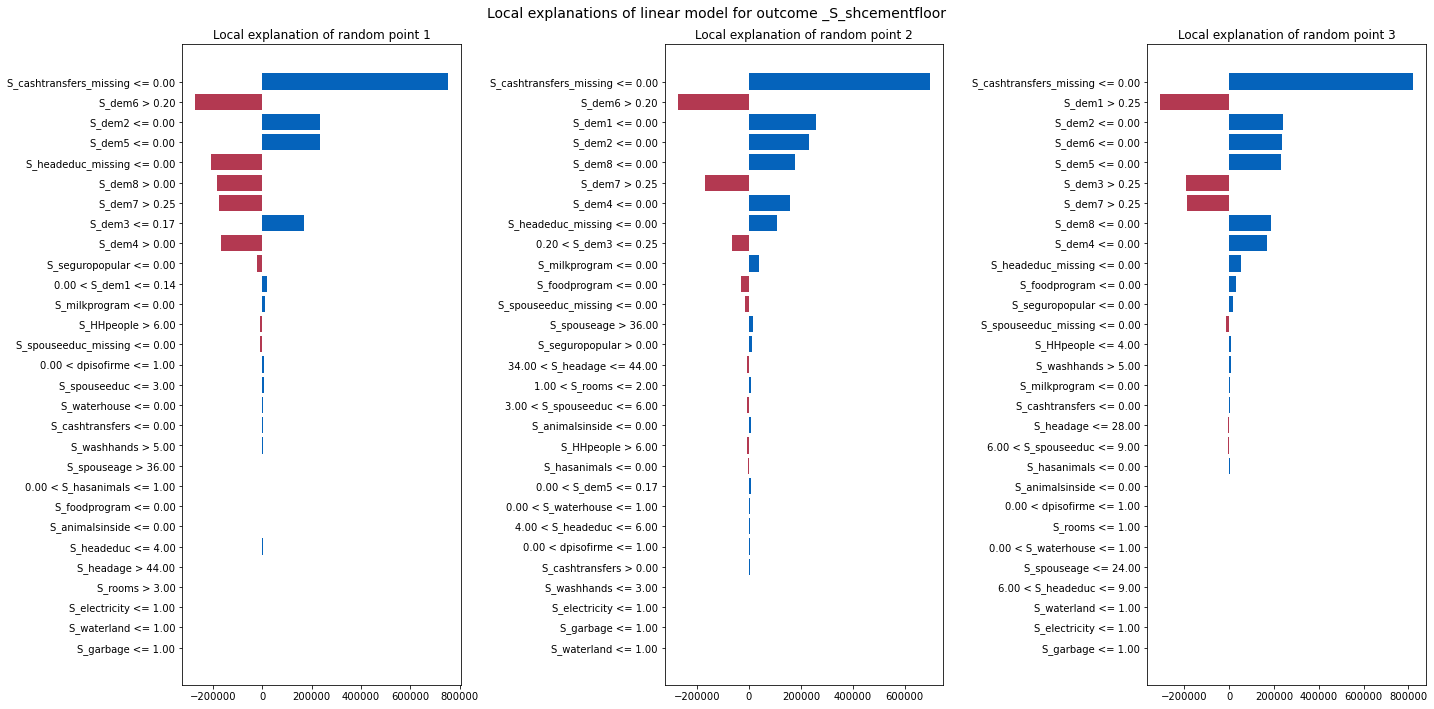

In [30]:
explain_random_datapoints('S_shcementfloor',model_type='linear',seed_points=0);

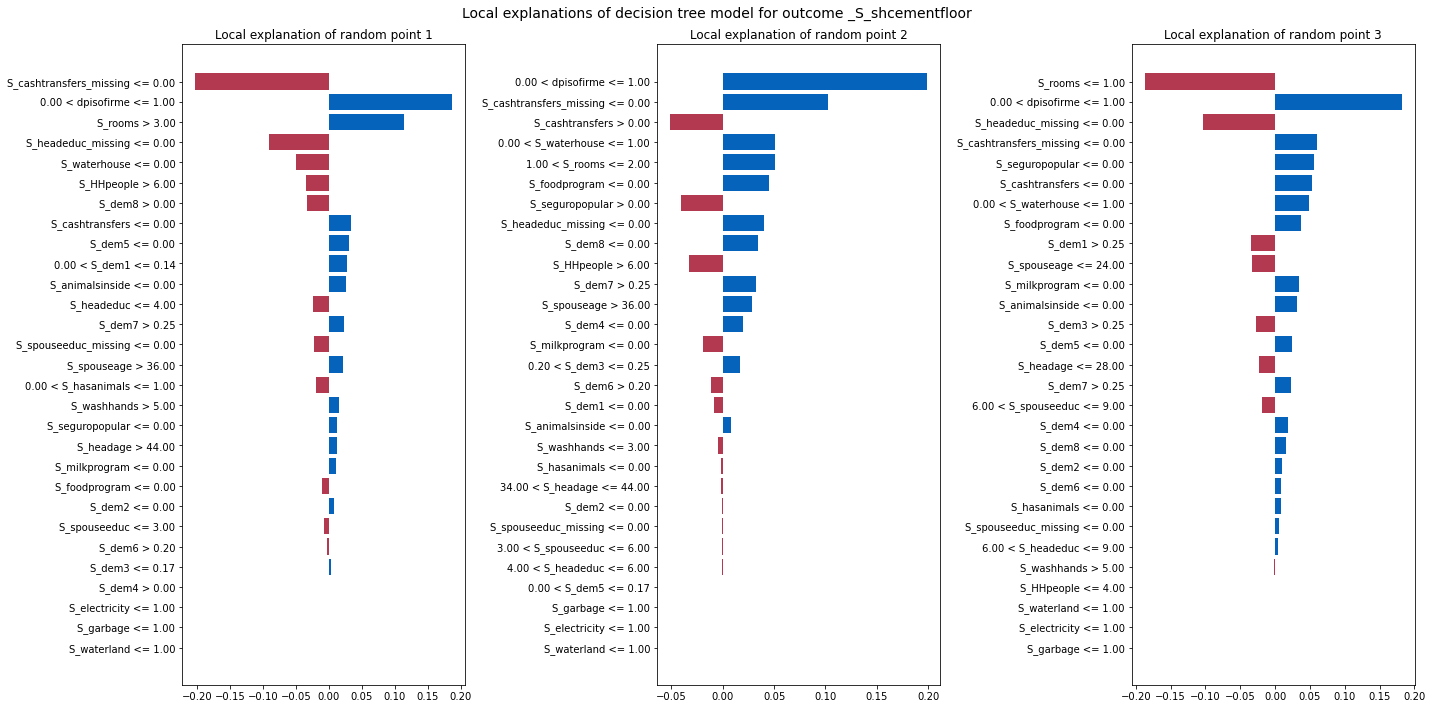

In [31]:
explain_random_datapoints('S_shcementfloor',model_type='decision tree',seed_points=0);

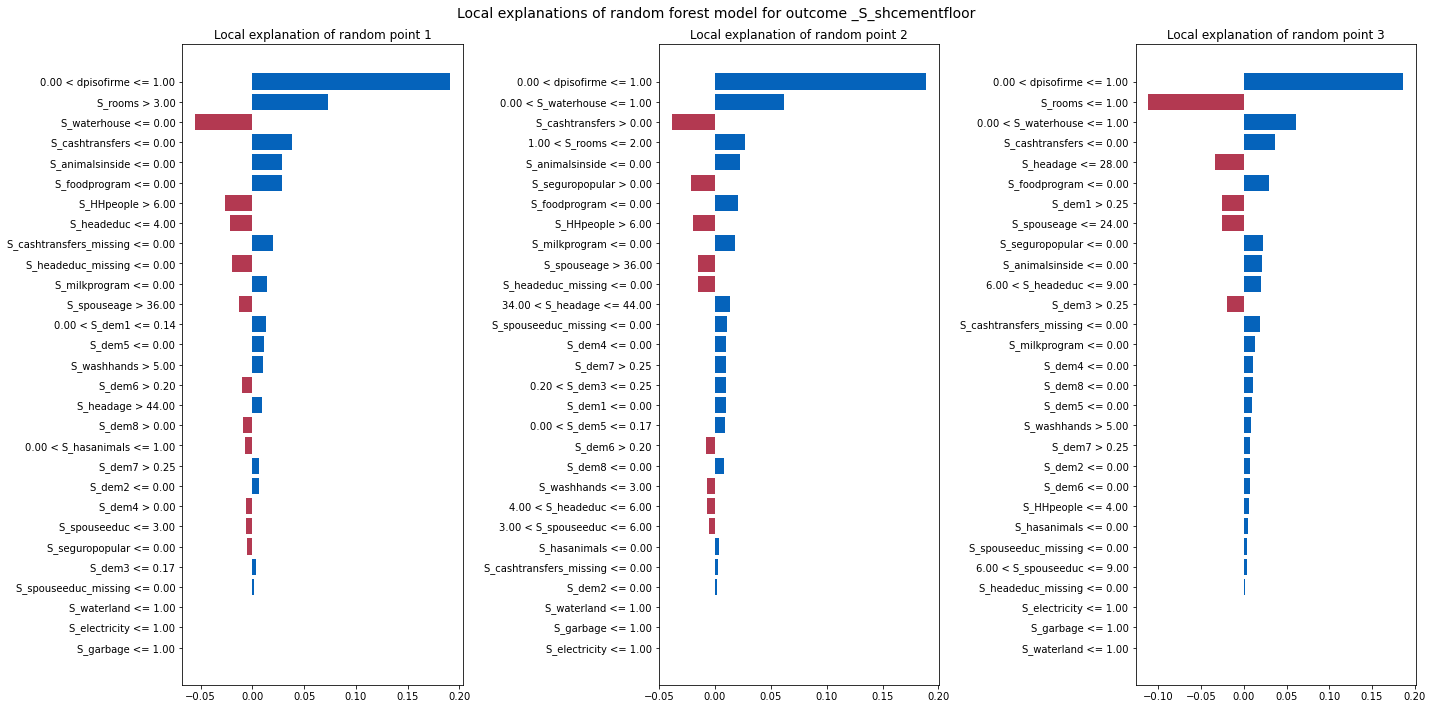

In [32]:
explain_random_datapoints('S_shcementfloor',model_type='random forest', seed_points=0);

From these local explanations, there are several observations we can make: 
- __Observations about the linear model local explanations__:
    - The local explanations of the linear model seem to emphasize the importance of  population variables `S_dem{i}`, which does not seem to be the case for decision tree and random forest models.
    - For the three randomly selected datapoints, the feature that correlates positively the most to the outcome of the local model is `S_cashtransfersmissing`. 
        If we were to take this at face value, it would be that the less likely for the information of cash transfers to be even available, the higher the share of cement floors. This ... does not really make  sense ! 
    - More importantly, or should we say more worringly, `dpisofirme` does not seem to hold much weight in the local interpretability of the datapoints. Remind you, this variable basically determines the presence or absence of treatment. 
- __Observations about the decision tree model local explanations__:
    
    - For the Decision Tree model, we observe that `S_cashtransfersmissing` still correlates strongly to the outcome, negatively for datapoint 1 and 
       positively for point 3. 
    - However, `dpisofirme` hold much more predictive power in the local interpretation of the decision tree model.  This seems to be in accordance with the results previously found in the SHAP analysis.
    - `S_rooms` holds  more predicitve power than in the linear model case. 
    - `S_cashtransfers` still holds considerable predicitve power, which is a variable that is not easily interpretable with respect to the outcome. 
    
- __Observations about the random forest model local explanations__:
   
    - For the three randomly selected datapoints, we have that `dpisofirme` is the most important predictor when it comes to the `S_shcementfloor` outcome, with consisteny across the three random datapoints. This is already more sensical and interpretable than the local explanations of the linear model.
    - Additionally, `S_cashtransfersmissing`, for this model,  correlates weakly to the outcome.

We observe that the results given by __LIME__ are not as consistent as the ones given by SHAP. Indeed, LIME is less computationally expensive and focuses first and foremost on local explanations, unlike SHAP which has both global and local aspects. Nevertheless, one of the three models, namely the Random Forest model, had local explanations that seemed to confirm the results found by SHAP globally for the same model. The problem with local interpretability, as shown, is that it doesn't give a good overview on the data, focusing only on particular observations. That is why, after this brief parentheses, we will return to SHAP values for the next analysis.

## _Step 5:_ Presence of water in the house and its correlation with diseases

We notice the importance of `S_waterhouse` for the previous outcomes. This leads to the following question: "is the presence of water in a household a significant predictor for the presence of diseases or cognitive development in children? If this is the case, would it have been more useful to bring water to the household instead of cement?" We repeat the previous analysis for several outcomes related to diseases and cognitive development (`S_diarrhea`, `S_anemia`, `S_parcount`,`S_mccdts`, etc ...) and try to assess the importance of the predictor `S_waterhouse` with respect to each of these outcomes.

### Substep 5.1: Linear regression

We use the exact same methodology as we did for the previous table, to assess the importance of each independent variable on the outcome. These independent variables are the same used by the authors in the paper.

In [33]:
# Defining the outcomes of this new analysis (individual dataset)
outcomes_table_5 = ['S_parcount', 'S_diarrhea', 'S_anemia', 'S_mccdts', 'S_pbdypct', 'S_haz', 'S_whz']

# Defining the independent variables
features_ind = ['dpisofirme', 'S_HHpeople', 'S_rooms', 'S_age', 'S_childma', 'S_childmaage',  'S_childmaeduc',  'S_childpa', 'S_childpaage', 'S_childpaeduc', 
                'S_waterland', 'S_waterhouse', 'S_electricity', 'S_hasanimals', 'S_animalsinside', 
                'S_garbage', 'S_washhands', 'S_cashtransfers', 'S_milkprogram', 'S_foodprogram', 'S_seguropopular', 'S_childmaage_missing',  'S_childmaeduc_missing', 'S_childpaage_missing',
               'S_childpaeduc_missing']


The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


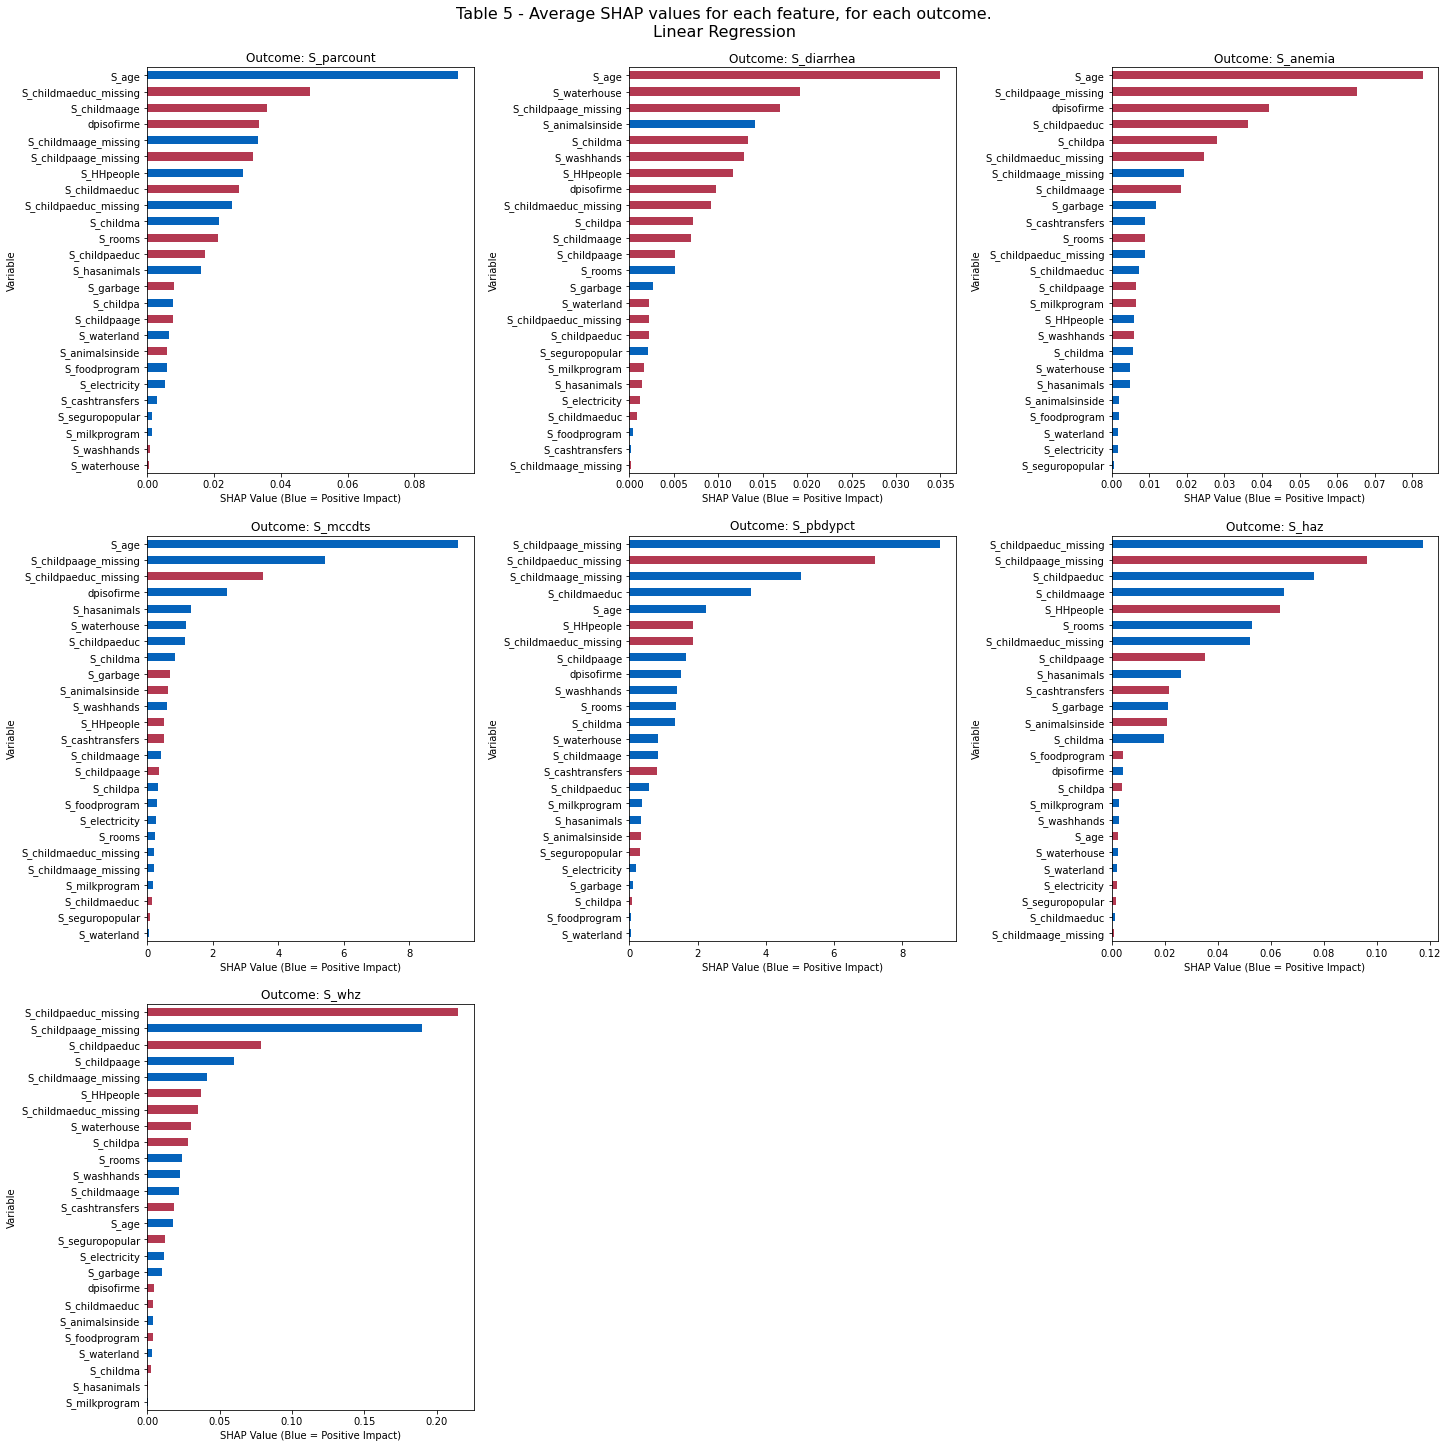

In [34]:
# Defining the subplots. Note: we can't share the X-axis right now, since the magnitude 
# of each coefficient is different
fig, axs = plt.subplots(3,3, figsize = (20, 20), constrained_layout = True)

for k, outcome in enumerate(outcomes_table_5):
    i= k // 3
    j= k % 3
    
    # Deleting missing values for each outcome in the independent variables
    data = individual[individual[outcome].notna()]
    nan_cols = data.columns[data.isna().any()].tolist()
    null_df = data[nan_cols].isnull().astype(int).add_suffix('_missing')
    data = data.merge(null_df, left_index = True, right_index = True).fillna(0)
    
    model = build_shap_plot(data, outcome, features_ind, axs[i, j], LinearRegression(), shap.LinearExplainer)
    axs[i, j].set_title(f'Outcome: {outcome}')

# Showing x ticks
for j in range(3):
    axs[0, j].xaxis.set_tick_params(labelbottom = True)

    
fig.delaxes(axs[2, 1])
fig.delaxes(axs[2, 2])
fig.suptitle('Table 5 - Average SHAP values for each feature, for each outcome.\nLinear Regression', fontsize = 16);

### Substep 5.1: Linear regression - result

Other than the impact of `dpisofirme`, which is not as significant as before, we notice, as expected, that the age of the child taken into account plays a significant role, especially for the variables directly related to diseases, namely `S_parcount`, `S_diarrhea` and `S_anemia`. In particular, it seems that, for the parasite count, this is positively correlated with the age of the person. This means that the older the child was in 2005, the higher was the count of parasites in its body (on average). For the other two variables we notice a significant **negative** correlation with the age. This can be considered normal, since some diseases are more related to young children, others to older ones. 

An important consideration must be made with respect to `S_waterhouse` and `S_washhands`: while for anemia and parasite count they don't seem to be so important, for diarrhea it is pretty clear that having water in the house higly reduces the risk of this disease. This might be only a coincidence (we repeat it: correlation doesn't mean causation), but it surely might be a starting point for future studies. Maybe, then, a program similar to Piso Firme could be offered to ensure every mexican has water (and, consequently, a better hygene) in their house. Also, having animals inside seems to be positively correlated with the same disease.

We don't notice other significant correlations in the other variables: often the one with the highest SHAP value is a *\_missing* one, which is just a dummy variable used to deal with null values, as explained in our respective replications. 

### Substep 5.2: Random Forest

We directly move our attention to a Random Forest model, without passing through a single decision tree this time, given that a Random Forest directly derives to a set of decision trees, to check if our assumption holds. 

In [ ]:
fig, axs = plt.subplots(3,3, figsize = (20, 20), constrained_layout = True)
for k, outcome in enumerate(outcomes_table_5):
    i= k // 3
    j= k % 3
    
    # Deleting missing values for each outcome in the independent variables
    data = individual[individual[outcome].notna()]
    nan_cols = data.columns[data.isna().any()].tolist()
    null_df = data[nan_cols].isnull().astype(int).add_suffix('_missing')
    data = data.merge(null_df, left_index = True, right_index = True).fillna(0)
    
    model = build_shap_plot(data, outcome, features_ind, axs[i, j], RandomForestRegressor(max_depth=10, random_state=0, n_estimators = 20), shap.TreeExplainer)
    axs[i, j].set_title(f'Outcome: {outcome}')

# Showing x ticks
for j in range(3):
    axs[0, j].xaxis.set_tick_params(labelbottom = True)

    
fig.delaxes(axs[2, 1])
fig.delaxes(axs[2, 2])
fig.suptitle('Table 5 - Average SHAP values for each feature, for each outcome. \nRandom Forest', fontsize = 16);

### Substep 5.3: Random Forest - results

Even if the order of feature's importance given by this Random Forest model, measured in terms of SHAP values, is slightly different by the one given by the simple linear regression model we used before, our conclusions about `S_parcount`, `S_diarrhea` and `S_anemia` still hold. In particular, not only we assess the importance of the age of the patient with respect to these diseases / health problems, but also, for the diarrhea, the negative correlation that `S_waterhouse` and `S_washhands` have with it. We can then confirm our idea: in order to fight some diseases Piso Firme had a positive impact, but with respect to diarrhea, it would have been better to bring water connection to the households first. Indeed, we also notice that with this more complex model, the impact of `dpisofirme` on `S_diarrhea` doesn't seem to be relevant. It would be interesting to repeat the same study done to assess the impact of Piso Firme, but with respect to a program of this kind.

## _Step 6:_ Conclusions

At the end of this journey, there are some conclusions that needs to be made:

- Firstly, we didn't observe a correlation between Piso Firme and the average income / assets per capita in 2005, at the time of the survey, as well as between the participation to the program and the natality rate. From this perspective, it could be interesting to conduct a long-term study to assess the economical and social benefits of these kind of programs. 
- Secondly, for tables 4 and 5 of the paper, the author's results still hold when we consider more advanced models and methods to assess the impact of a feature on the decided outcomes.
- With respect to table 4, we noticed that there are other variables that might have conditioned people who received the bonus on where to put the cement in their house. We noticed mexican people tend to be pretty democratic from this point of view: if there are many rooms (and thus many bedrooms), they often decided to put cement in a common room, to be fair with every member of the family.
- Again, with respect to table 4, we noticed a significant impact for the dummy variable `S_waterhouse`, which is equal to 1 if the household had continuous access to water within their house and 0 otherwise, especially when the outcome was `S_cementfloorbat`. This is of course understandable, as we tried to explain, and gives us something to think about: mexican government had to make a choice about how to spend its money in terms of social programs. We saw how successful Piso Firme has been, what would happen with a program of this kind, with the aim of bringing water to every house?
- With respect to table 5, we proved that what the authors claimed in the paper is true (although the effect of Piso Firme doesn't seem to be as important as for the previous table, but this was expected, given the nature of the outcomes). Then we tried to assess the impact of `S_waterhouse` on children-related health variables. We noticed a significant negative correlation with the diarrhea "disease". This is, again, explainable: households with no access to water in their houses probably don't have a proper bathroom either. This exposes everyone, especially children, with low immunitary defense, to diseases and infections. Again, this made us think about the importance of a program to bring water to mexican houses.

To conclude: the authors of "House, Health and Happiness" are definetly right about the impact of Piso Firme on the general well being of mexican people, but for us it has been more interesting to see how many hypotheses, claims and theories can be formulated analysing datasets like the provided ones. We hope you found this journey as fascinating as we did.